# Configuration

In [5]:
n_phi_sectors        = 9
polynomial_degree_dr = 4
polynomial_degree_z  = 4

n_photons = 1e7
#n_photons = 3e6
#n_photons = 1e6
#n_photons = 3e5
#n_photons = 1e5

z_min =  10
z_max = 530
r_max = 300
r_max = 198

# Setup

In [6]:
import os
import shutil
import collections

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
from   matplotlib        import patches

import invisible_cities.core .core_functions as coref
import invisible_cities.core . fit_functions as  fitf
import invisible_cities.icaro. hst_functions as  hstf

In [7]:
path_tables         = "/Volumes/SAMSUNG/NEWtables/S1/"
path_thesis         = "/Users/Gonzalo/github/tese/img/"
filename_dr_data    = os.path.join(path_tables, "Fake"  , "dr_data.dat")
filename_dr_fit     = os.path.join(path_tables, "Fake"  ,  "dr_fit.dat")
filename_z_data     = os.path.join(path_tables, "Fake"  ,  "z_data.dat")
filename_z_fit      = os.path.join(path_tables, "Fake"  ,   "z_fit.dat")
filename_pull_data  = os.path.join(path_tables, "Fake"  ,    "pull.dat")
filename_table      = os.path.join(path_tables, "S1_aug", "S1table.dat")

filename_active_map = os.path.join(path_tables,  "active_mapping.dat")
filename_pmt_map    = os.path.join(path_tables,     "pmt_mapping.dat")

In [8]:
profile = collections.namedtuple("profile", "x y u")

In [9]:
%matplotlib inline

plt.rcParams["figure.figsize"   ] = 24, 16
plt.rcParams[ "lines.markersize"] = 15
plt.rcParams[ "lines.linewidth" ] = 3
plt.rcParams[  "font.size"      ] = 40
plt.rcParams[  "grid.linewidth" ] =  3
plt.rcParams[  "grid.linestyle" ] = "--"
plt.rcParams[  "grid.alpha"     ] = 0.5

In [10]:
def load_df(filename, df_active, df_pmt, zmin=0, zmax=530, rmax=205, nphi=9):
    two_pi   = 2 * np.pi

    df_table = pd.DataFrame.from_csv(filename, sep=" ", index_col=None)
    x_active = df_table. PointID.map(df_active.X)
    y_active = df_table. PointID.map(df_active.Y)
    z_active = df_table. PointID.map(df_active.Z)
    x_pmt    = df_table.SensorID.map(df_pmt   .X)
    y_pmt    = df_table.SensorID.map(df_pmt   .Y)
    phi      = df_table.SensorID.map(df_pmt   .Phi)
    s        = np.sin(phi)
    c        = np.cos(phi)
    dx       = x_active - x_pmt
    dy       = y_active - y_pmt
    r_active = np.sqrt(x_active**2 + y_active**2)

    df_table["Prob"      ] = df_table.Prob * 100
    df_table["Ring"      ] = df_table.SensorID.map(df_pmt.Corona)
    df_table["Uncert"    ] = np.clip(np.sqrt(df_table.Prob / n_photons), 5/n_photons, np.inf)
    df_table["dR"        ] = np.sqrt(dx**2 + dy**2)
    df_table["dPhi"      ] = (np.arctan2(dy, dx) - phi + two_pi) % two_pi
    df_table["dPhi_index"] = dphi_to_index(df_table.dPhi, nphi)
    df_table["X"         ] = x_active 
    df_table["Y"         ] = y_active 
    df_table["Z"         ] = z_active 
    df_table["R"         ] = r_active 

    new_columns = ["PointID", "SensorID", "Ring", "dR", "dPhi", "X", "Y", "Z", "dPhi_index", "R", "Prob", "Uncert"]
    df_table    = df_table[df_table.R <= rmax]
    df_table    = df_table[df_table.Z >= zmin]
    df_table    = df_table[df_table.Z <= zmax]
    df_table    = df_table.reindex(columns = new_columns)
    df_table.sort_values("SensorID")
    return df_table

def dphi_to_index(dphi, n_sectors):
    dphi_sector_width = np.pi / n_sectors
    dphi = np.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
    return (dphi // dphi_sector_width).astype(int)

def generate_seed(degree, ydata):
    return (1,) * degree + (np.mean(ydata),)

def save(name, dpi=200, *args, **kwargs):
    plt.savefig(os.path.join(path_thesis, name), *args, dpi=dpi, **kwargs)

In [85]:
pmt       = pd.DataFrame.from_csv(filename_pmt_map   , sep=" ", index_col=0)
active    = pd.DataFrame.from_csv(filename_active_map, sep=" ", index_col=0)
dr_data   = pd.DataFrame.from_csv(filename_dr_data   , sep=" ", index_col=None)
dr_fit    = pd.DataFrame.from_csv(filename_dr_fit    , sep=" ", index_col=None)
z_data    = pd.DataFrame.from_csv(filename_z_data    , sep=" ", index_col=None)
z_fit     = pd.DataFrame.from_csv(filename_z_fit     , sep=" ", index_col=None)
pull_data = pd.DataFrame.from_csv(filename_pull_data , sep=" ", index_col=None)
df_table  = load_df(filename_table, active, pmt, zmin=z_min, zmax=z_max, rmax=r_max, nphi=n_phi_sectors)

In [12]:
df_table.head()

PointID  SensorID  Ring          dR      dPhi    X   Y   Z  dPhi_index  \
24516     2043         0     0  193.653765  1.709625 -195 -25  10           4   
24517     2043         1     0  152.711335  5.221973 -195 -25  10           3   
24518     2043         2     0  264.248860  3.364753 -195 -25  10           8   
24519     2043         3     1  286.574598  2.393215 -195 -25  10           6   
24520     2043         4     1  183.258469  2.015326 -195 -25  10           5   

                R      Prob    Uncert  
24516  196.596033  0.000561  0.000007  
24517  196.596033  0.000552  0.000007  
24518  196.596033  0.000564  0.000008  
24519  196.596033  0.000412  0.000006  
24520  196.596033  0.000413  0.000006

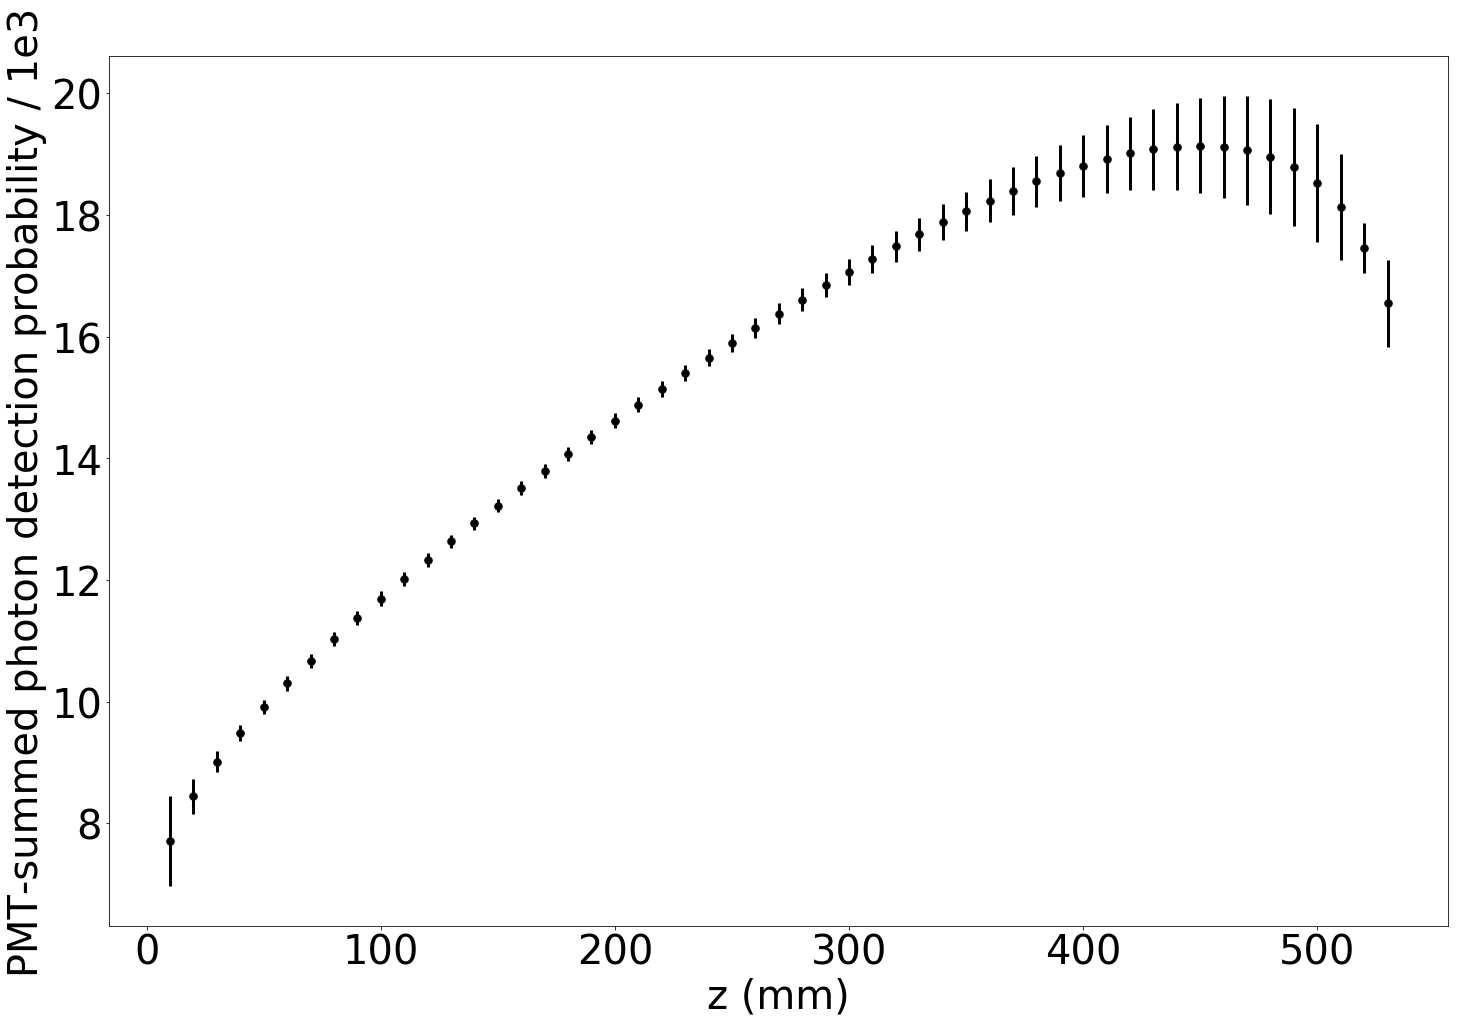

In [13]:
df       = df_table.copy()
df.Prob *= 1e3

zs      = []
probs   = []
uncerts = []
for z, z_dat in df.groupby("Z"):
    xy_dat  = z_dat.groupby(["X", "Y"])
    prob    = np.average(xy_dat.Prob.sum())
    uncert  = np.std    (xy_dat.Prob.sum())# / len(pmt)**0.5

    zs     .append(z)
    probs  .append(prob)
    uncerts.append(uncert)

plt.errorbar(zs, probs, uncerts, fmt=".k")
#plt.ylim(gb.Prob.min().min() * 0.9, gb.Prob.max().max() * 1.1)
plt.xlabel("z (mm)")
plt.ylabel("PMT-summed photon detection probability / 1e3")
save("new_s1_sum_vs_z.png")

In [14]:
pmt

X         Y           R       Phi  Corona
SensorID                                                  
0         -23.9414   65.7785   70.000012  1.919862       0
1         -44.9951  -53.6231   69.999971 -2.268928       0
2          68.9365  -12.1554   69.999963 -0.174533       0
3          -0.0000  185.0000  185.000000  1.570796       1
4        -118.9160  141.7180  185.000018  2.268930       1
5        -182.1890   32.1249  184.999570  2.967059       1
6        -160.2150  -92.5000  185.000260 -2.617995       1
7         -63.2737 -173.8430  184.999864 -1.919862       1
8          63.2737 -173.8430  184.999864 -1.221730       1
9         160.2150  -92.5000  185.000260 -0.523598       1
10        182.1890   32.1249  184.999570  0.174533       1
11        118.9160  141.7180  185.000018  0.872663       1

In [15]:
active.head()

X    Y  Z
PointID             
0       -215 -215  0
1       -215 -205  0
2       -215 -195  0
3       -215 -185  0
4       -215 -175  0

# Control plots

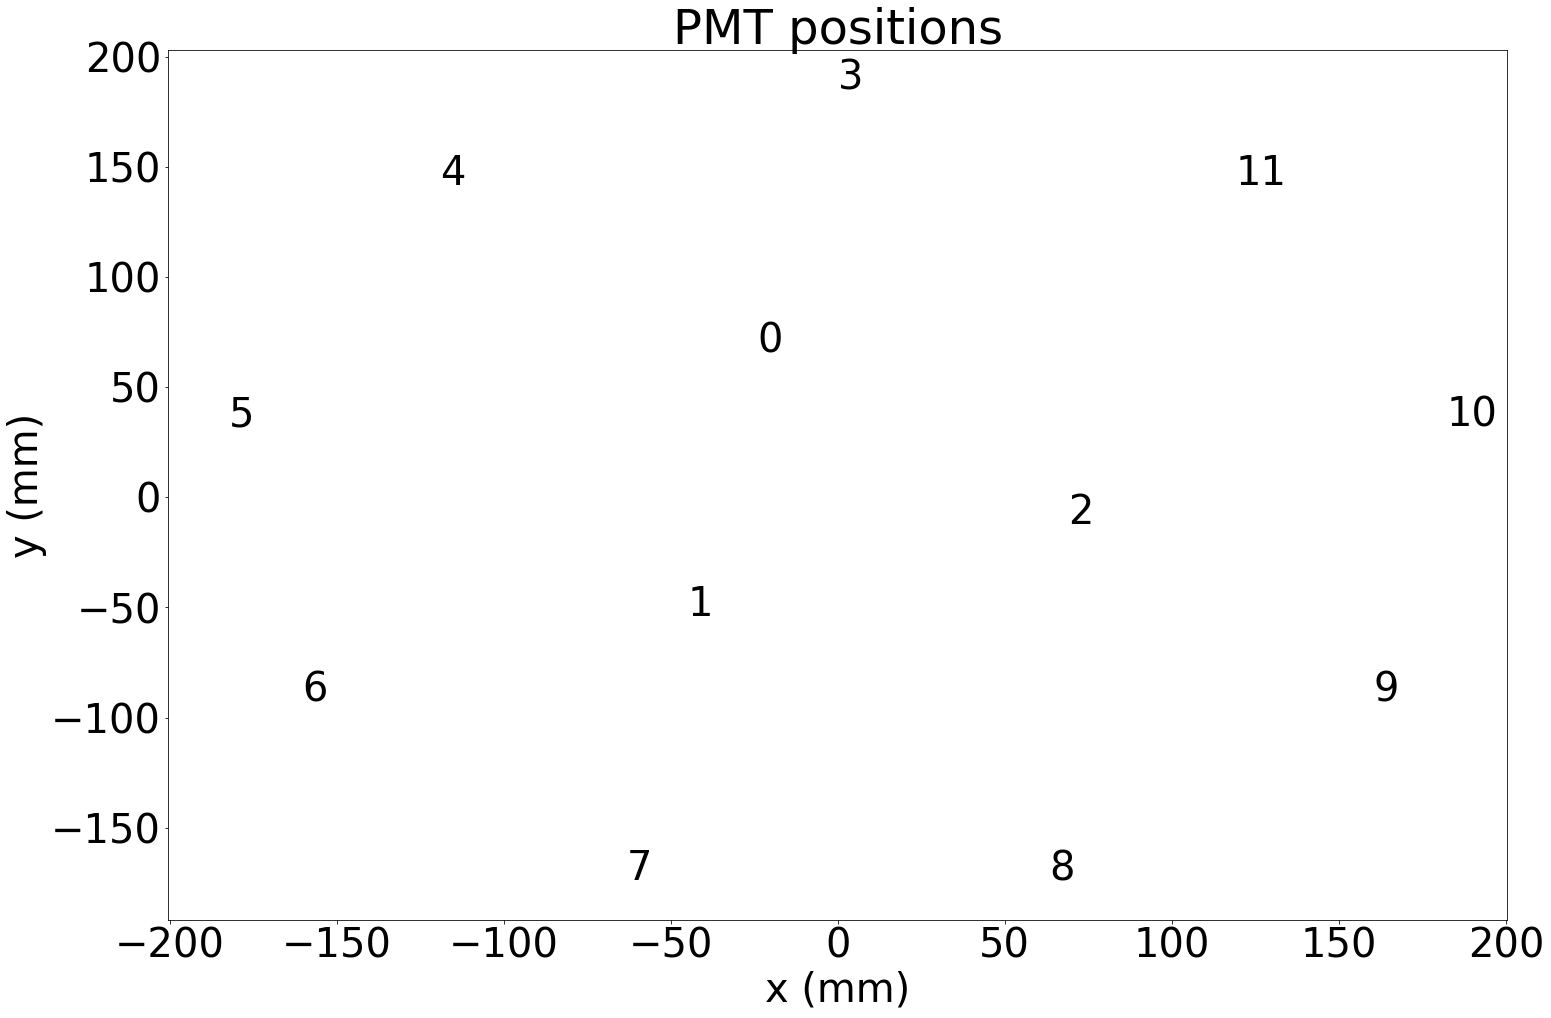

In [16]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(pmt_no)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT positions");

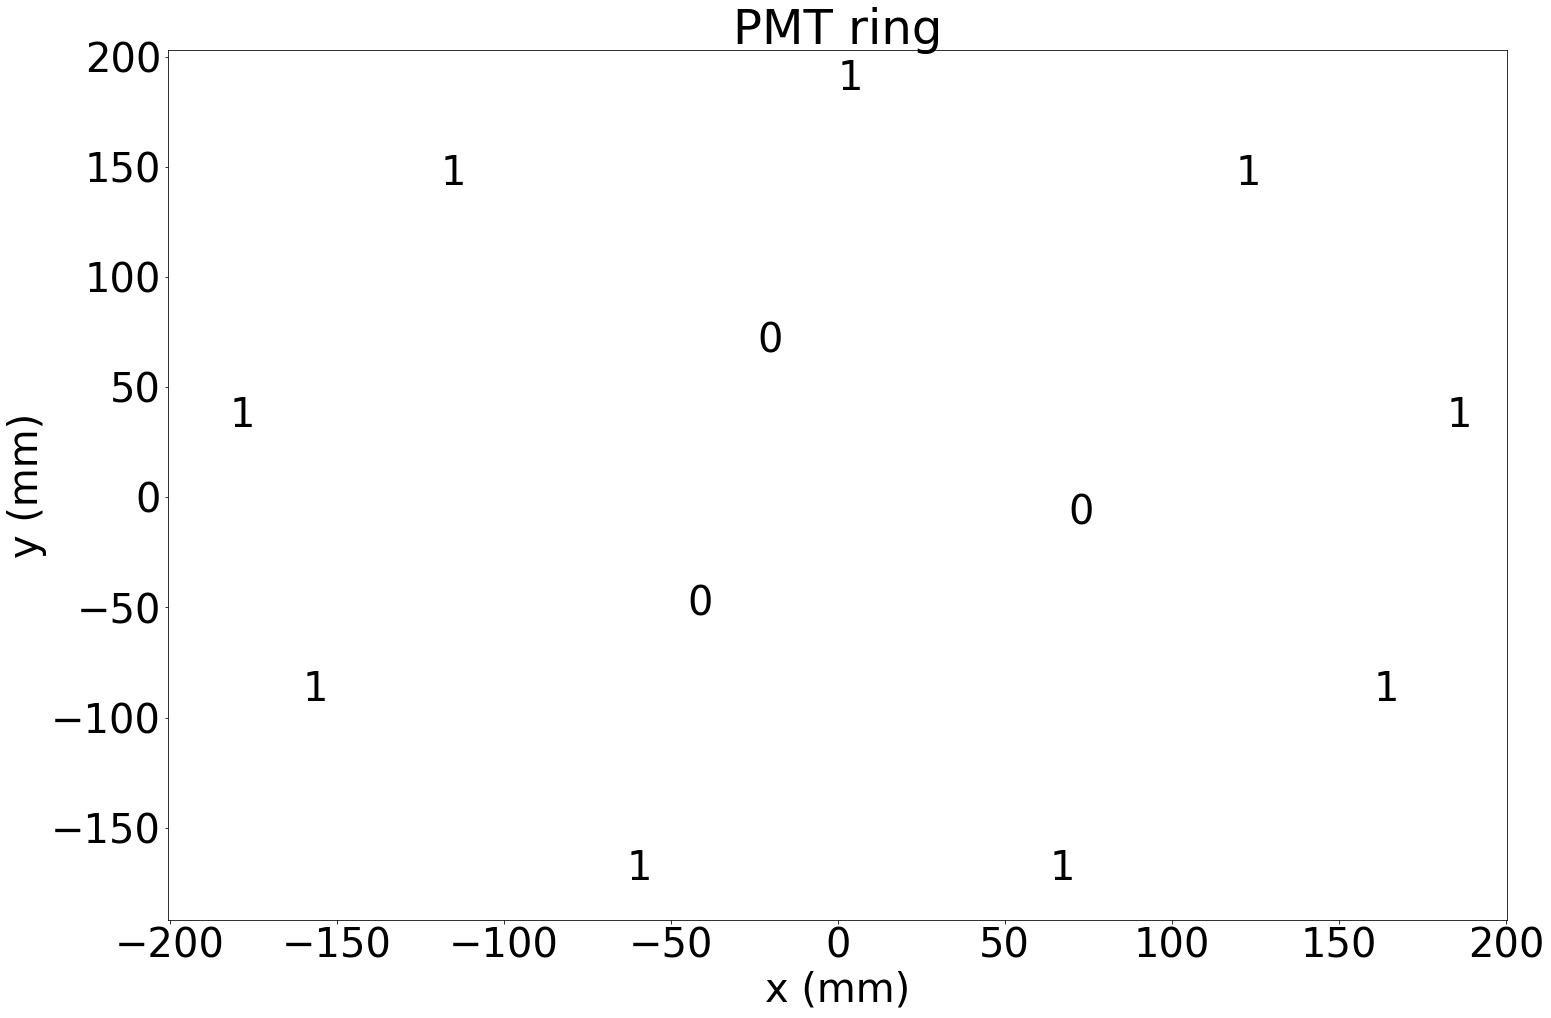

In [17]:
plt.scatter(pmt.X, pmt.Y, s=0)
for pmt_no, row in pmt.iterrows():
    plt.text(row.X, row.Y, str(int(row.Corona)))
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("PMT ring");

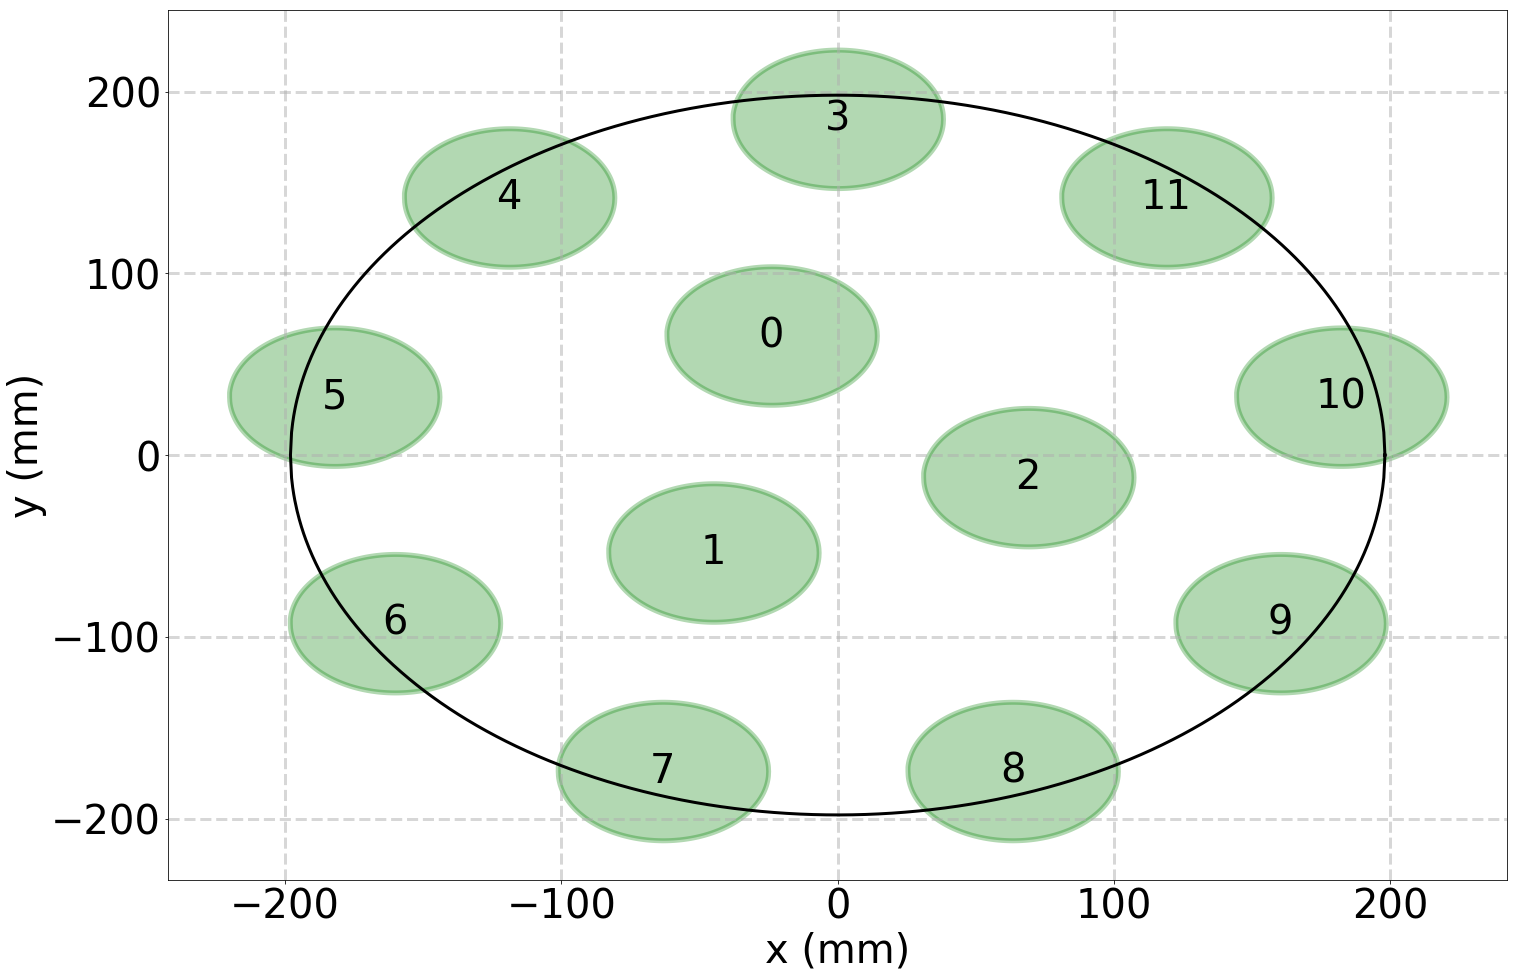

In [18]:
R = 198

x1 = np.linspace(+R, -R, 1000, endpoint=False)
y1 = +(R**2 - x1**2)**0.5
x2 = np.linspace(-R, +R, 1000)
y2 = -(R**2 - x2**2)**0.5

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
plt.plot(x, y, "k", lw=3)

#plt.plot([-R, R], [ 0, 0], "r")
#plt.plot([ 0, 0], [-R, R], "r")

for pmt_no, row in pmt.iterrows():
    r  = 3 * 25.4 / 2
    x1 = np.linspace(+r, -r, 1000, endpoint=False)
    y1 = row.Y + (r**2 - x1**2)**0.5
    x2 = np.linspace(-r, +r, 1000)
    y2 = row.Y - (r**2 - x2**2)**0.5

#    x = np.concatenate([x1, x2]) + row.X
#    y = np.concatenate([y1, y2])
#    plt.plot(x, y, "g", lw=2)
#    plt.fill_between(x1 + row.X, y2, y1, facecolor="None", hatch="x", edgecolor="m", lw=5)
    plt.fill_between(x1 + row.X, y2, y1, facecolor="g", edgecolor="g", lw=5, alpha=0.3)
    plt.text(row.X, row.Y, str(int(pmt_no)),
             horizontalalignment="center",
             verticalalignment="center")

plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

plt.grid()

save("new_pmt_positions.png")

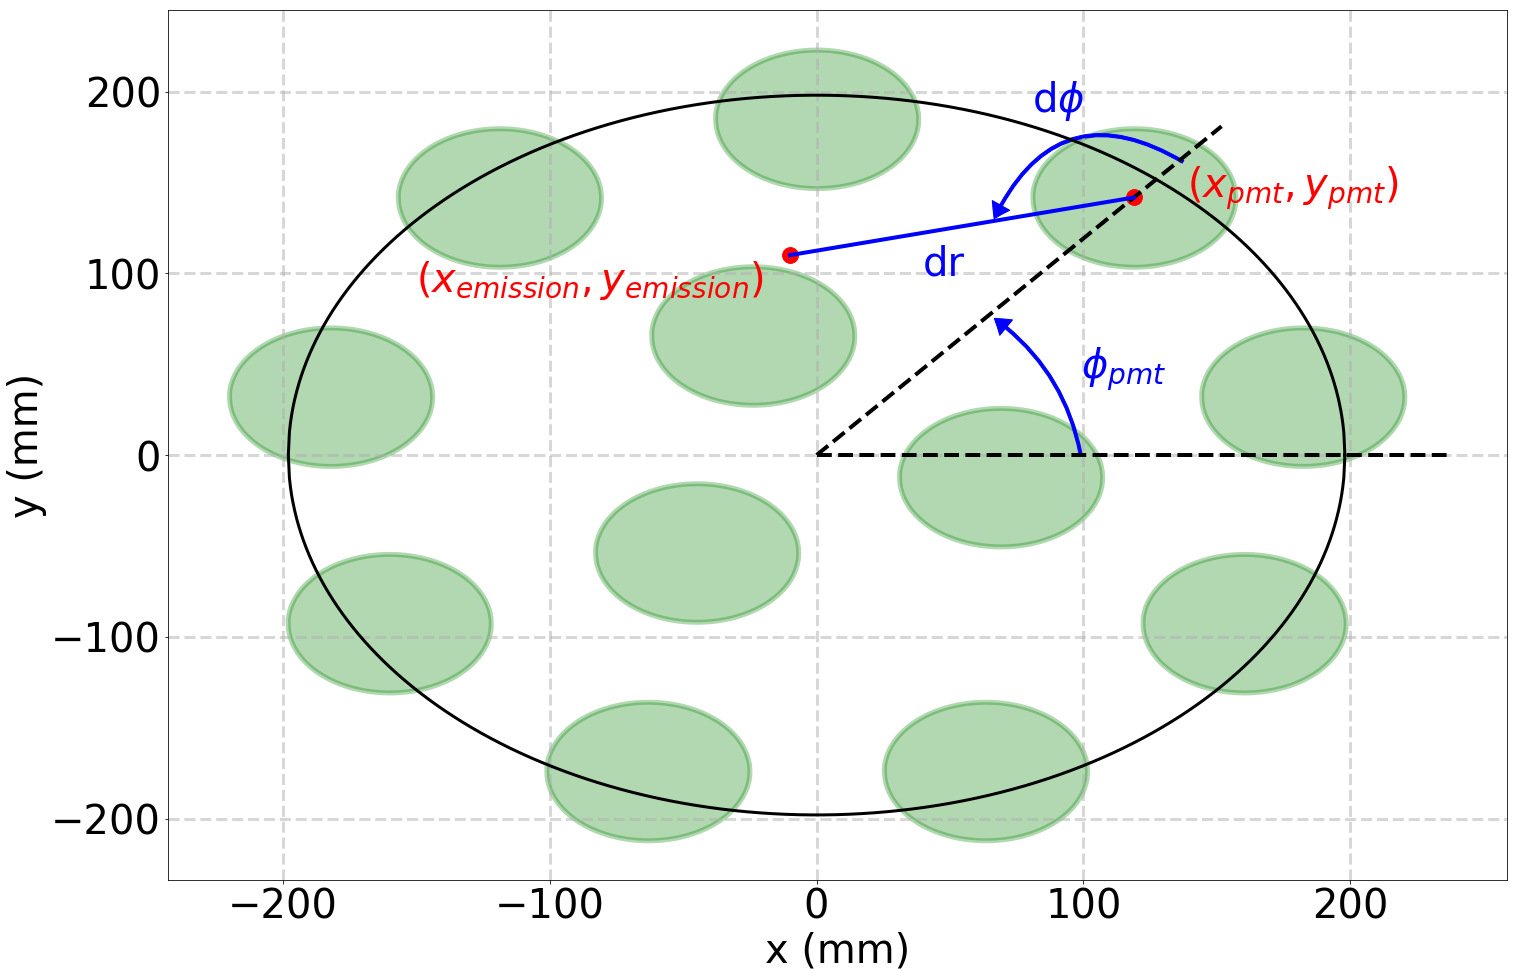

In [152]:
R = 198

x1 = np.linspace(+R, -R, 1000, endpoint=False)
y1 = +(R**2 - x1**2)**0.5
x2 = np.linspace(-R, +R, 1000)
y2 = -(R**2 - x2**2)**0.5

x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
plt.plot(x, y, "k", lw=3)

for pmt_no, row in pmt.iterrows():
    r  = 3 * 25.4 / 2
    x1 = np.linspace(+r, -r, 1000, endpoint=False)
    y1 = row.Y + (r**2 - x1**2)**0.5
    x2 = np.linspace(-r, +r, 1000)
    y2 = row.Y - (r**2 - x2**2)**0.5

    plt.fill_between(x1 + row.X, y2, y1, facecolor="g", edgecolor="g", lw=5, alpha=0.3)
    
pmt0 = 11
phi0 = pmt.Phi[pmt0]
x0, y0 = pmt.X[pmt0], pmt.Y[pmt0]
xr, yr = (R+r) * np.cos(phi0), (R+r) * np.sin(phi0)
x1, y1 = -10, 110

plt.plot   ([ 0, R+r], [ 0,  0], "k--", lw=  4) # y = 0
plt.plot   ([ 0,  xr], [ 0, yr], "k--", lw=  4) # y = tan(phi0) * x
plt.plot   ([x0,  x1], [y0, y1], "b-" , lw=  4) # from pmt to point
plt.scatter([x0,  x1], [y0, y1], c="r", s =250) # from pmt to point

plt.text(x0 / 3  , y0 * 0.7, "dr", color="b")
plt.text(x0 + 20 , y0      , "($x_{pmt}, y_{pmt}$)", color="r")
plt.text(x1 - 140, y1 - 20 , "($x_{emission}, y_{emission}$)", color="r")

style      = "Simple,tail_width=3,head_width=20,head_length=15"
connection = "arc3,rad=.2"
arrowkw    = dict(connectionstyle = connection,
                  arrowstyle      = style,
                  color           = "b")
arrowphi0 = patches.FancyArrowPatch((R/2, 0), (R/3, R/2 * np.sin(phi0)), **arrowkw)
plt.gca().add_patch(arrowphi0)
plt.text(R / 2, R / 2 * np.sin(phi0/2), r"$\phi_{pmt}$", color="b")

style      = "Simple,tail_width=3,head_width=20,head_length=15"
connection = "arc3,rad=.55"
arrowkw    = dict(connectionstyle = connection,
                  arrowstyle      = style,
                  color           = "b")
arrowdphi = patches.FancyArrowPatch((x0 + r/2, y0 + r/2),
                                    (x1 + r*2, y1 + r/2), **arrowkw)
plt.gca().add_patch(arrowdphi)
plt.text(x0 - r, y0 + r*1.25, "d$\phi$", color="b")


plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.grid()

save("new_s1_parametrization_coordinates_definition.png")

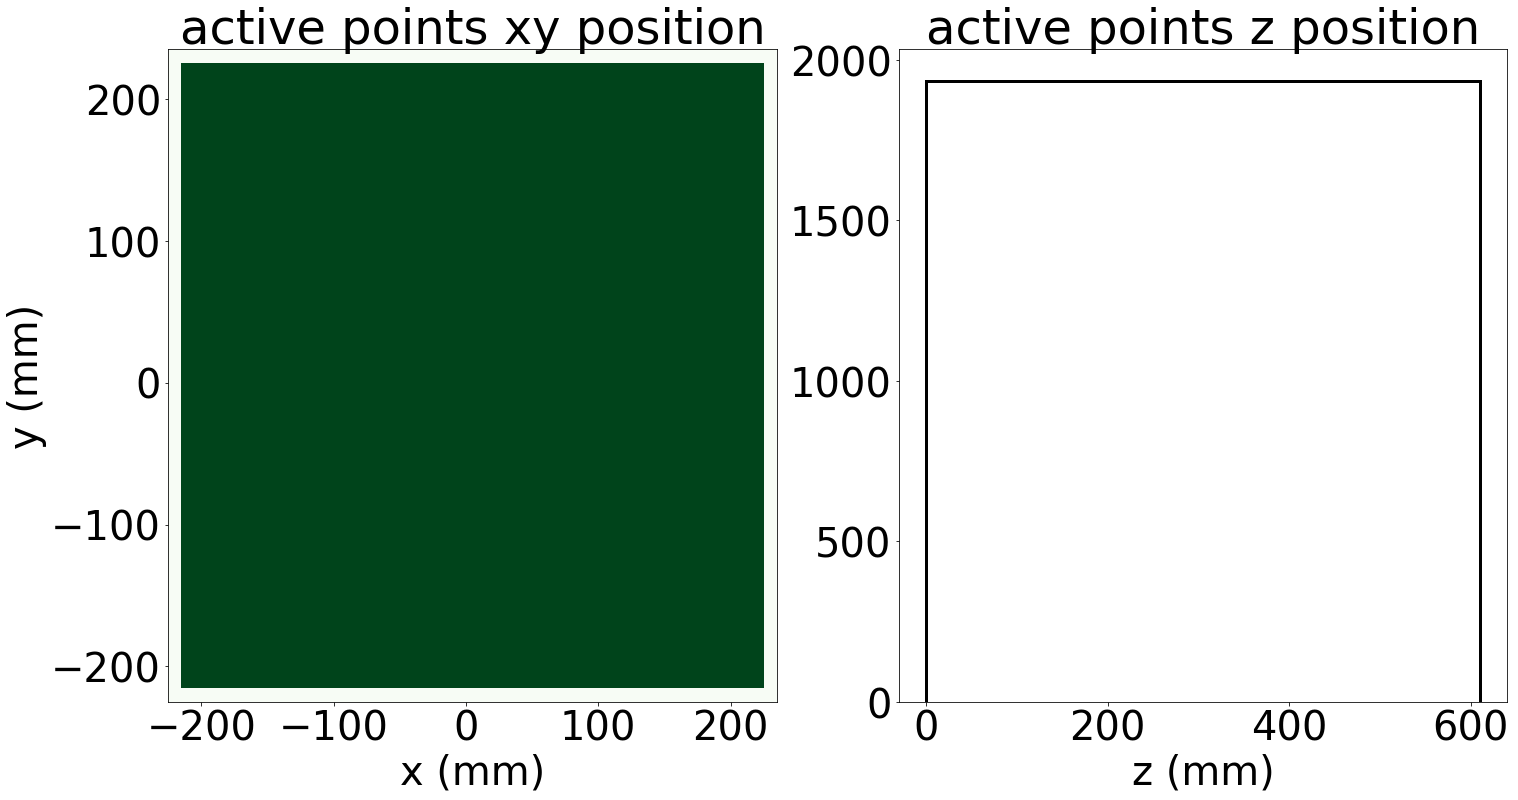

In [20]:
xy_binning = (np.arange(np.min(active.X) - 10, np.max(active.X) + 20 + 1, 10),
              np.arange(np.min(active.Y) - 10, np.max(active.Y) + 20 + 1, 10))
z_binning = np.arange(np.min(active.Z) - 1e-5, np.max(active.Z) + 1 + 1e-5, 10)

plt.figure(figsize=(24, 12))
plt.subplot(1, 2, 1)
plt.hist2d(active.X, active.Y, xy_binning, cmap="Greens")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.title ("active points xy position")

plt.subplot(1, 2, 2)
plt.hist(active.Z, z_binning, histtype="step", color="k", lw=3)
plt.xlabel("z (mm)")
plt.title ("active points z position");

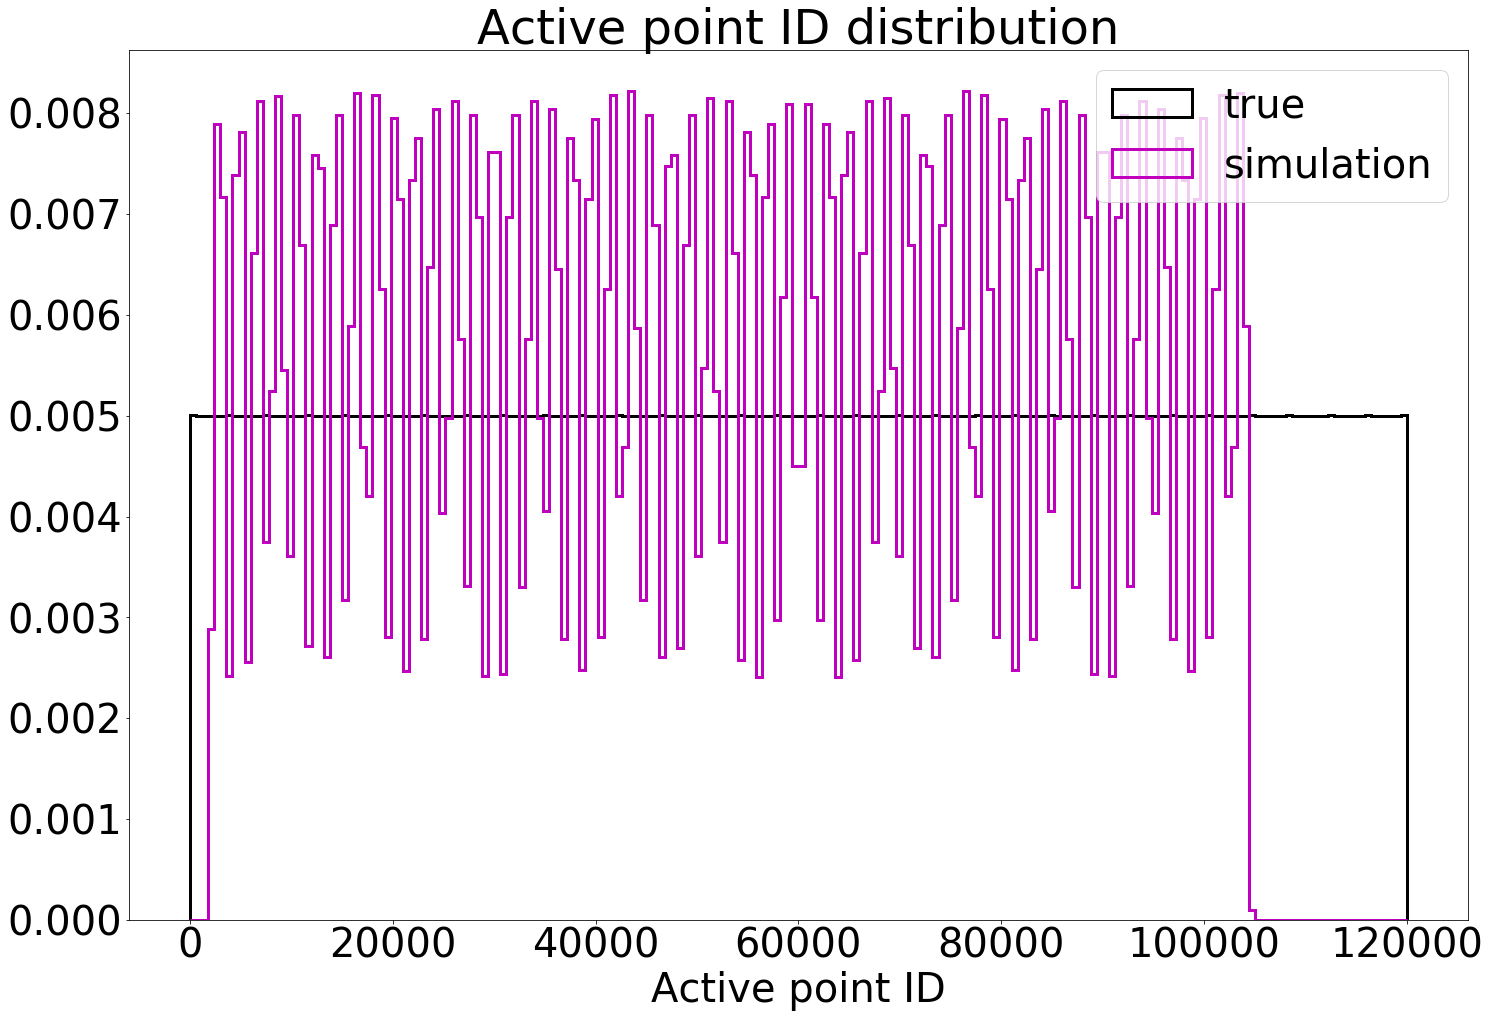

In [21]:
bins = np.linspace(active.index.min(), active.index.max(), 201)

weights = np.ones(len(active)) / len(active)
plt.hist(active.index, bins=bins, weights=weights, color="k", histtype="step", lw=3, label="true")

weights = np.ones(len(df_table)) / len(df_table)
plt.hist(df_table.PointID, bins=bins, weights=weights, color="m", histtype="step", lw=3, label="simulation")

plt.legend()
plt.xlabel("Active point ID")
plt.ylabel("")
plt.title ("Active point ID distribution");

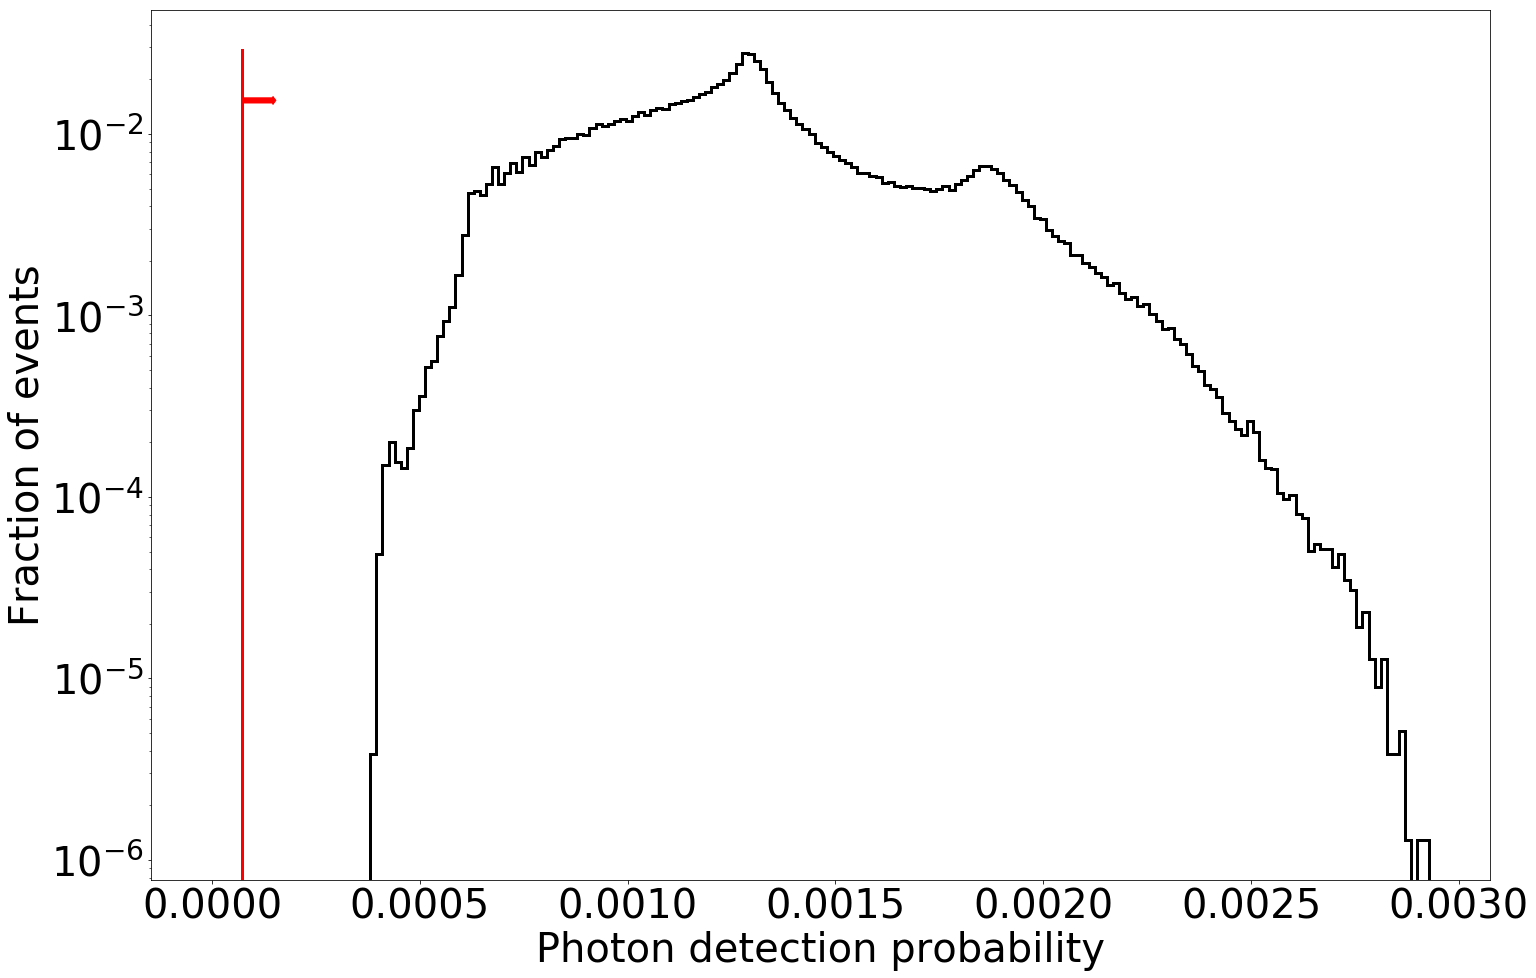

In [22]:
bins    = np.linspace(0, max(df_table.Prob), 201)
weights = np.ones(len(df_table)) / len(df_table)

y, x, _ = plt.hist(df_table.Prob, bins = bins, weights = weights, color="k", histtype="step", lw=3)

cut = x[:-1][y == 0][5]
plt.plot([cut, cut], plt.ylim(), "r-", lw=3)
plt.arrow(cut, np.mean(plt.ylim()), cut, 0,
          color="r", head_length=0.1*cut, head_width=0.1*np.mean(plt.ylim()))

plt.xlabel("Photon detection probability")
plt.ylabel("Fraction of events")
plt.yscale("log")

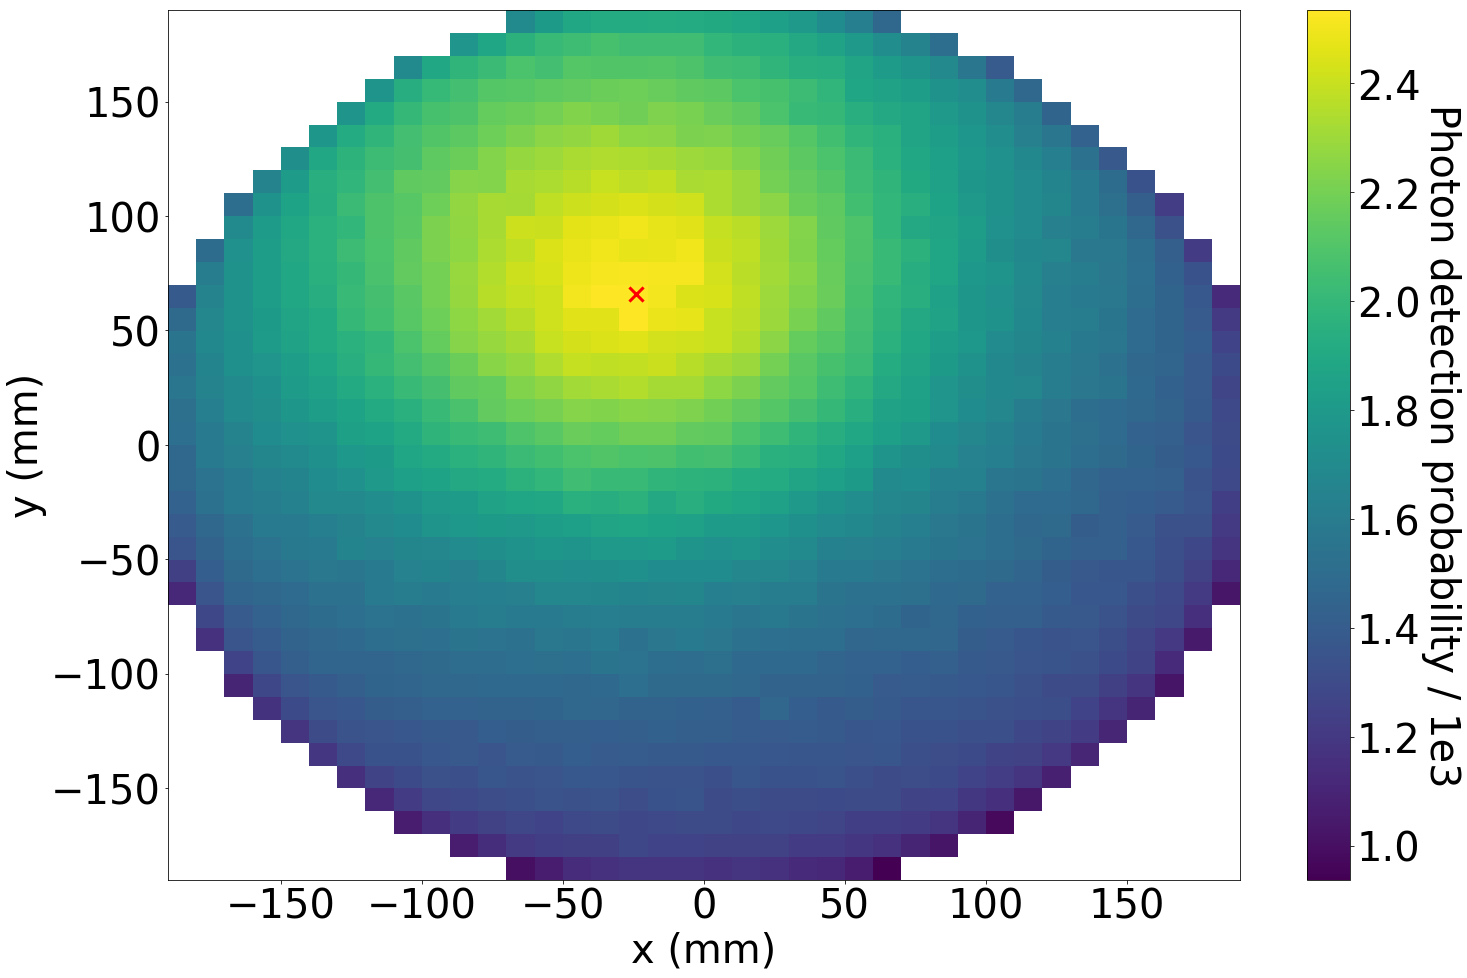

In [23]:
sel  = df_table.SensorID ==   0
sel &= df_table.Z        == 530

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 10),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 10))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 0]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save("new_s1_table_inner_pmt_z_530.png", dpi=200)

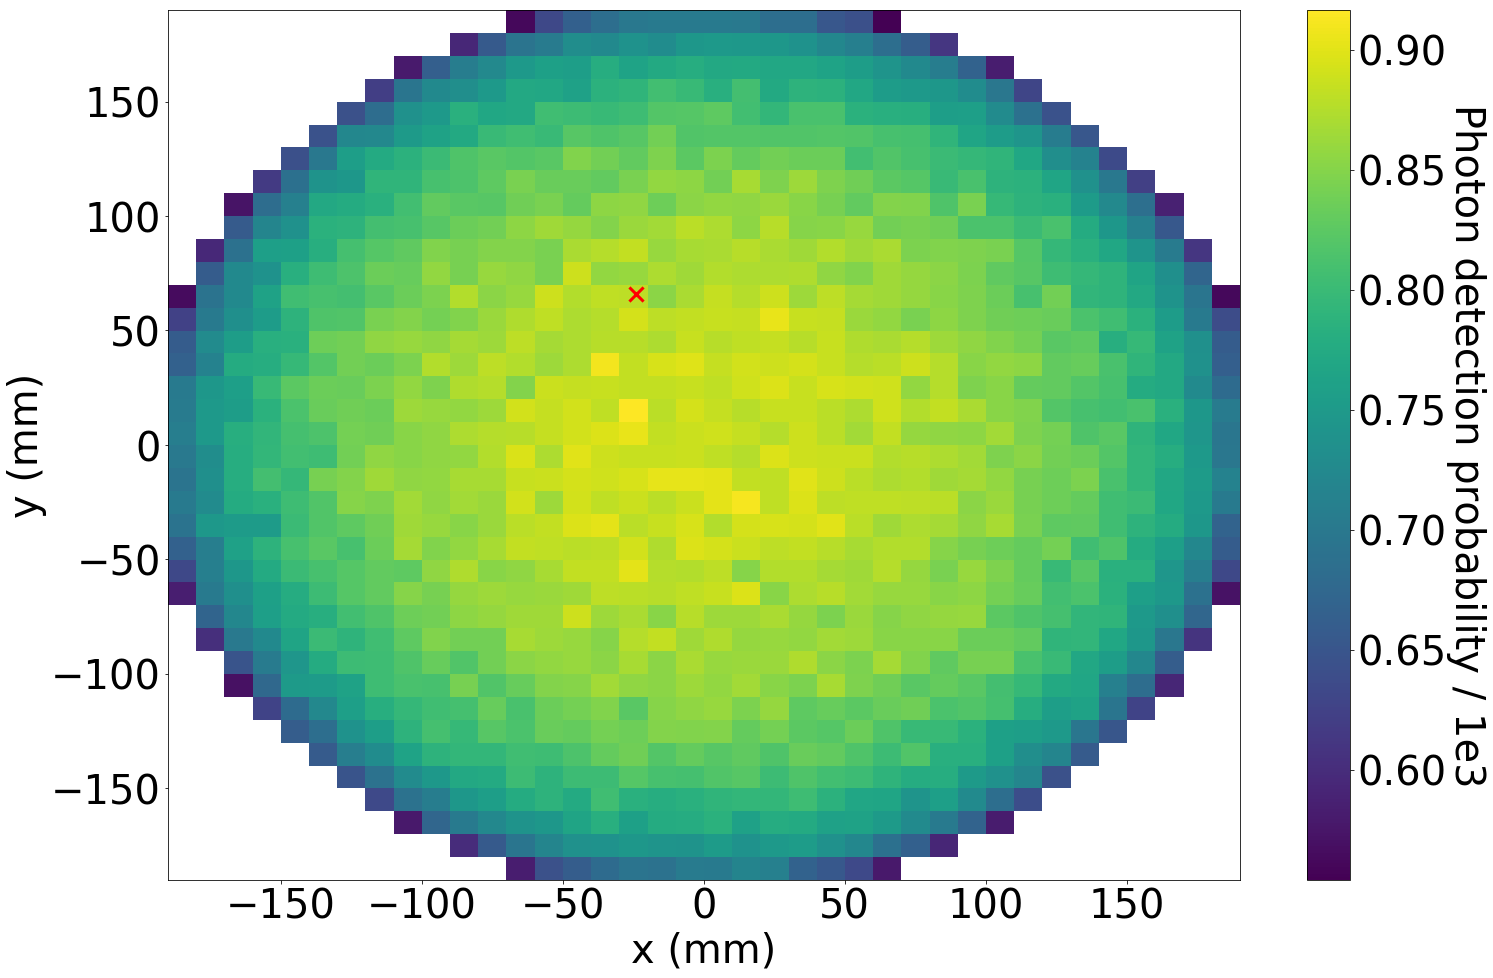

In [24]:
sel  = df_table.SensorID ==  0
sel &= df_table.Z        == 10

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 10),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 10))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 0]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save("new_s1_table_inner_pmt_z_10.png", dpi=200)

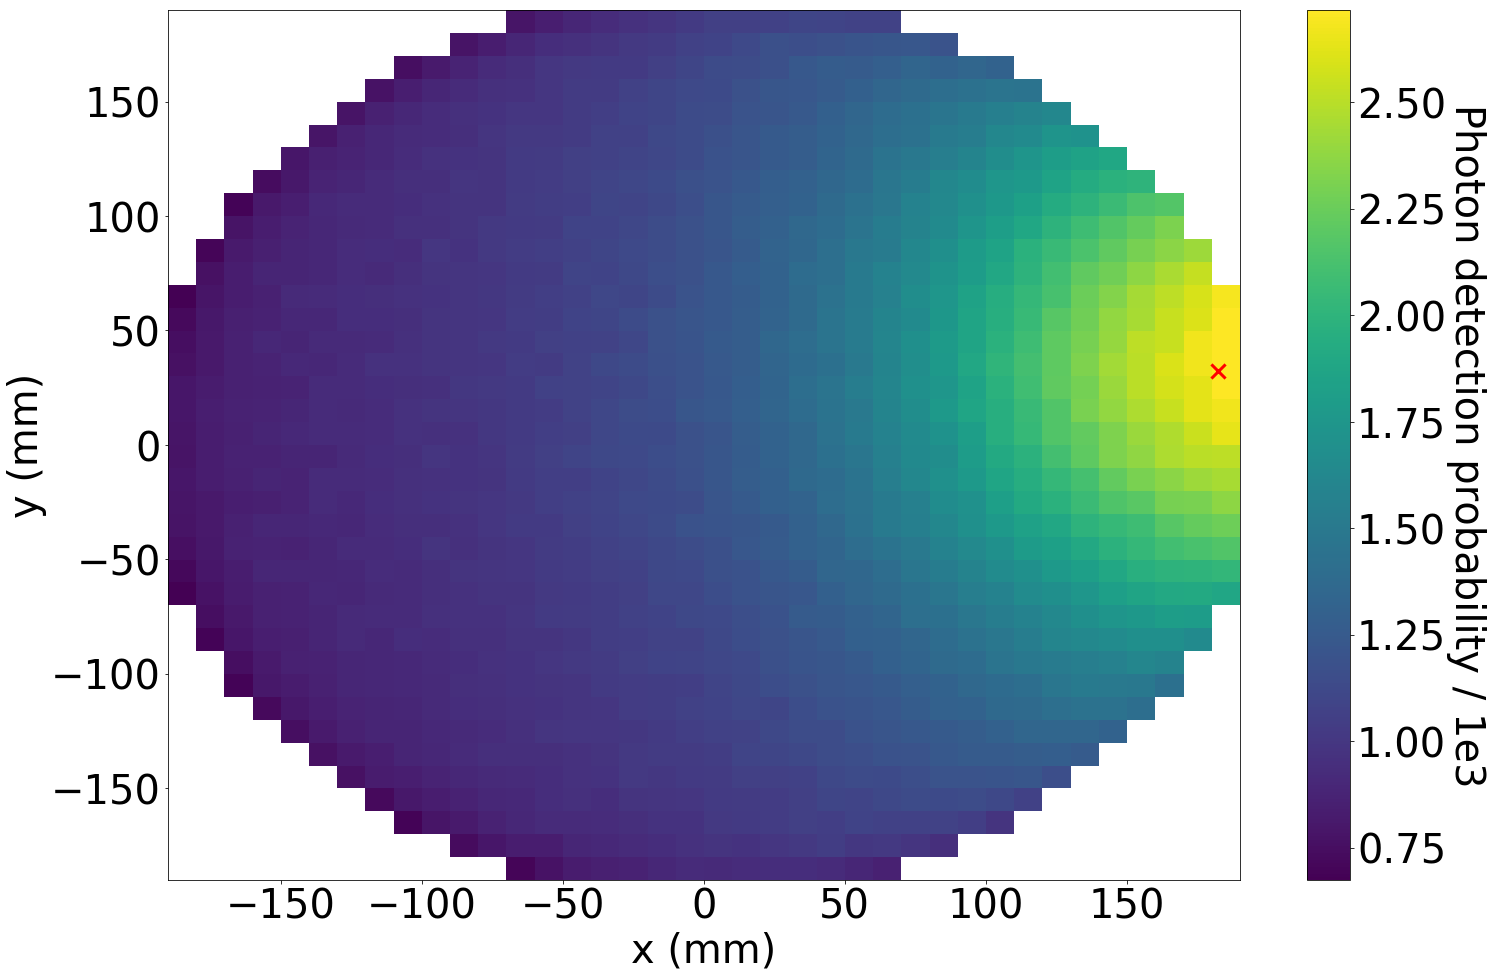

In [25]:
sel  = df_table.SensorID ==  10
sel &= df_table.Z        == 530

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 10),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 10))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 10]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save("new_s1_table_outer_pmt_z_530.png", dpi=200)

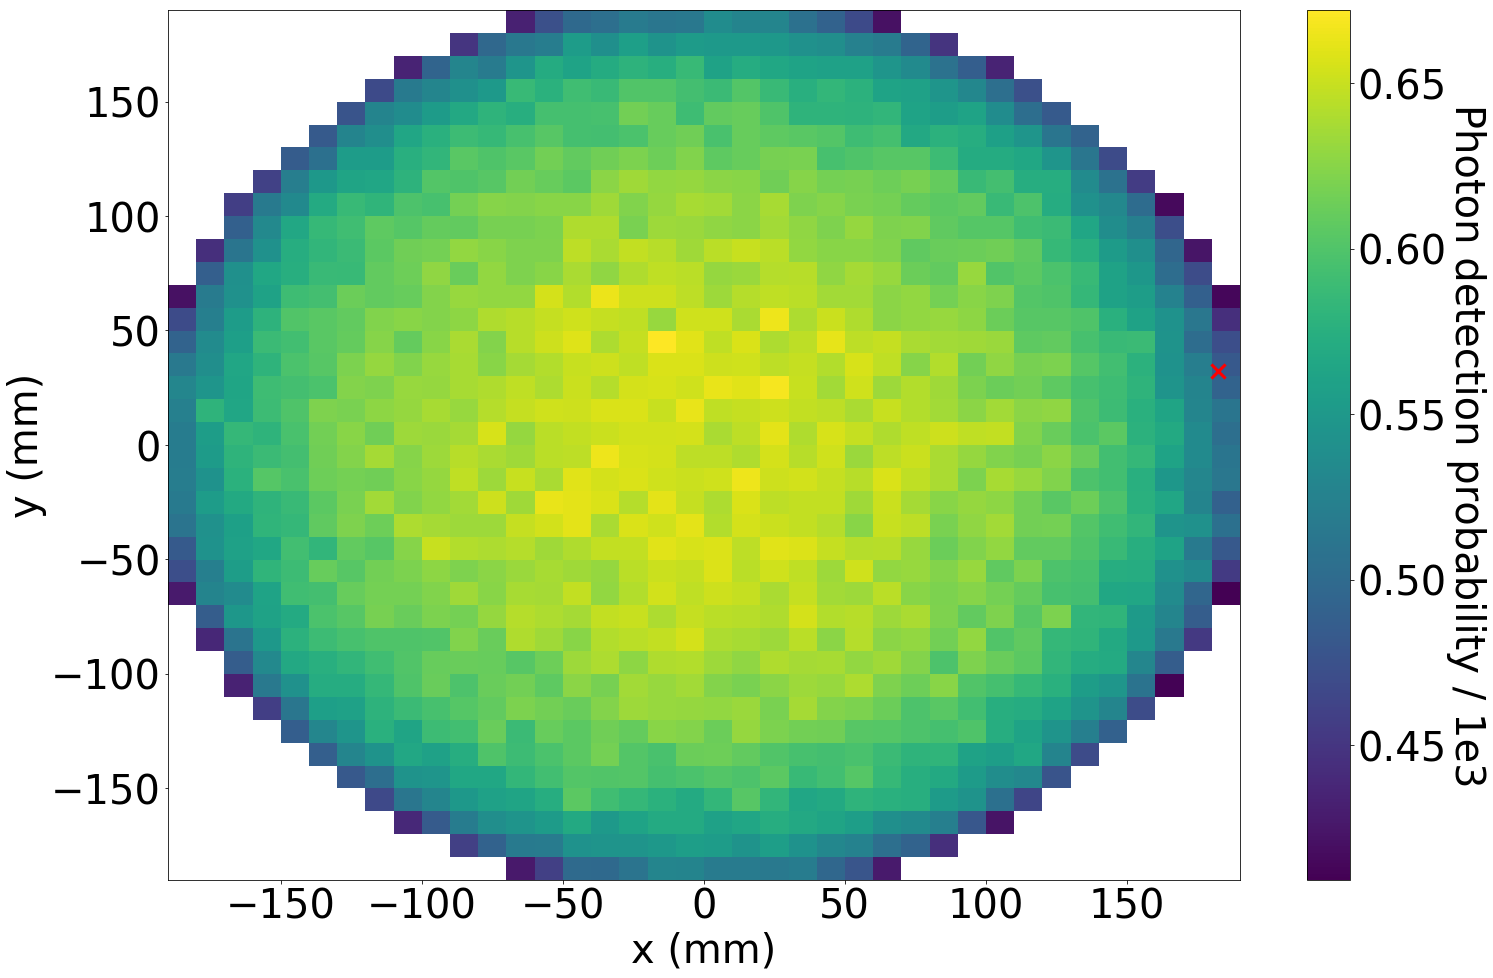

In [26]:
sel  = df_table.SensorID == 10
sel &= df_table.Z        == 10

xy_binning = (np.arange(np.min(active.X) + 25  , np.max(active.X) - 25 + 1, 10),
              np.arange(np.min(active.Y) + 25  , np.max(active.Y) - 25 + 1, 10))

df   = df_table[sel].copy()
df.Prob *= 1e3
gb   = df.groupby(["X", "Y"])
plt.hist2d(gb.X.mean(), gb.Y.mean(), bins=xy_binning,
           weights = gb.Prob.mean(),
           cmin    = gb.Prob.min ().min())
plt.colorbar().set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

thispmt = pmt[pmt.index == 10]
plt.scatter(thispmt.X, thispmt.Y, s=200, marker="x", c="r")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

save("new_s1_table_outer_pmt_z_10.png", dpi=200)

# PMT parametrization

In [27]:
print(f"Selecting data with P > {cut*1e5:.3f} · 10^{-5}")
df_table = df_table[df_table.Prob > cut]

Selecting data with P > 7.323 · 10^-5


In [28]:
dr_binning   = np.linspace(0, df_table.dR.max() * 1.001, 101)
dphi_binning = np.linspace(0, 2 * np.pi * 1.001, 101)
p_binning    = np.linspace(0, np.max(df_table.Prob) * 1.001, 101)

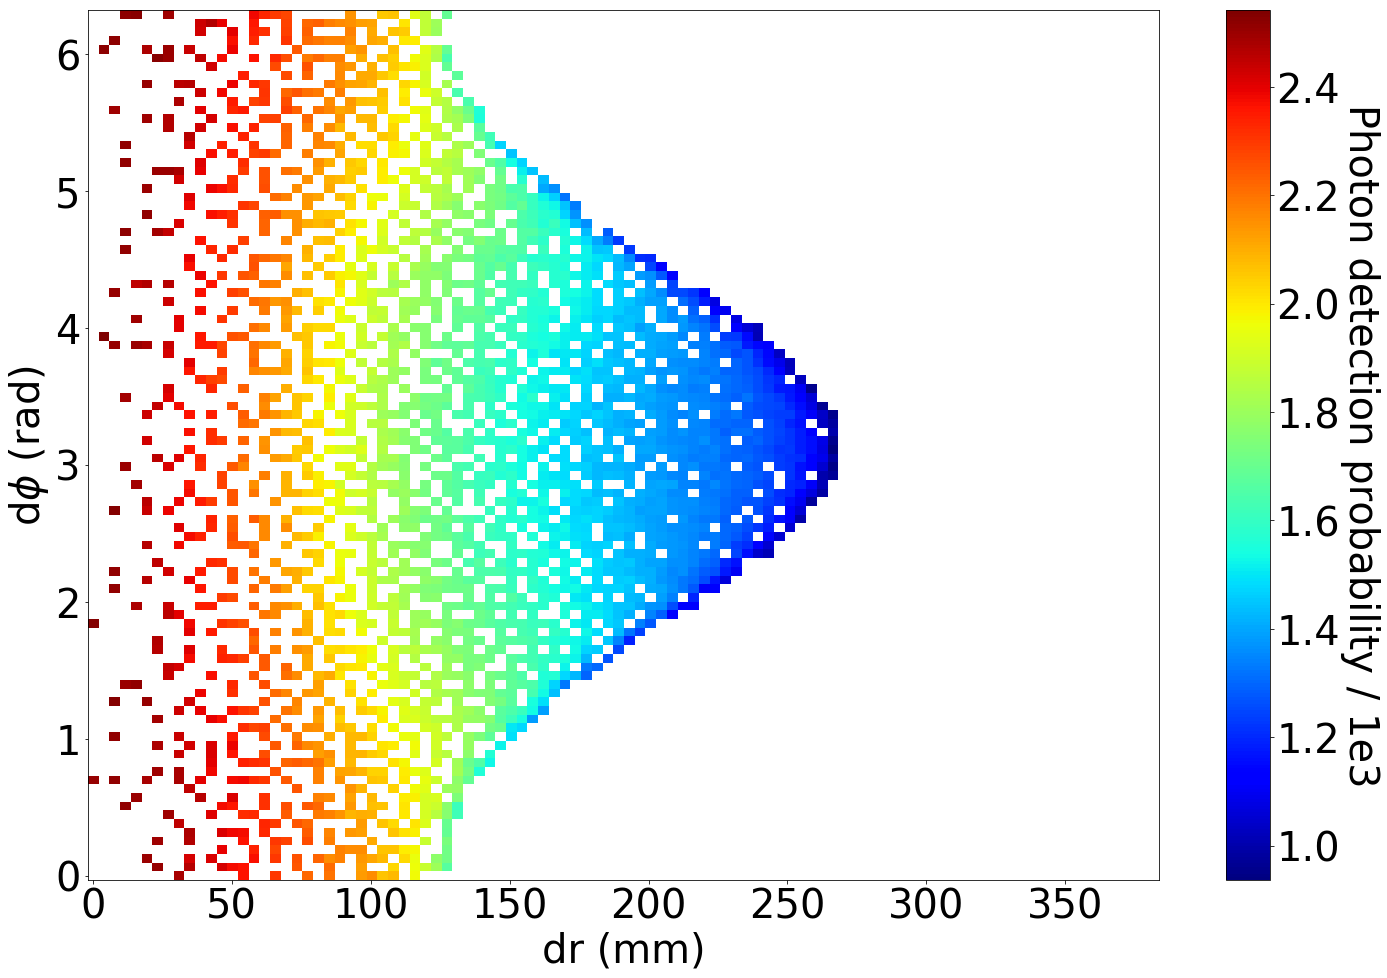

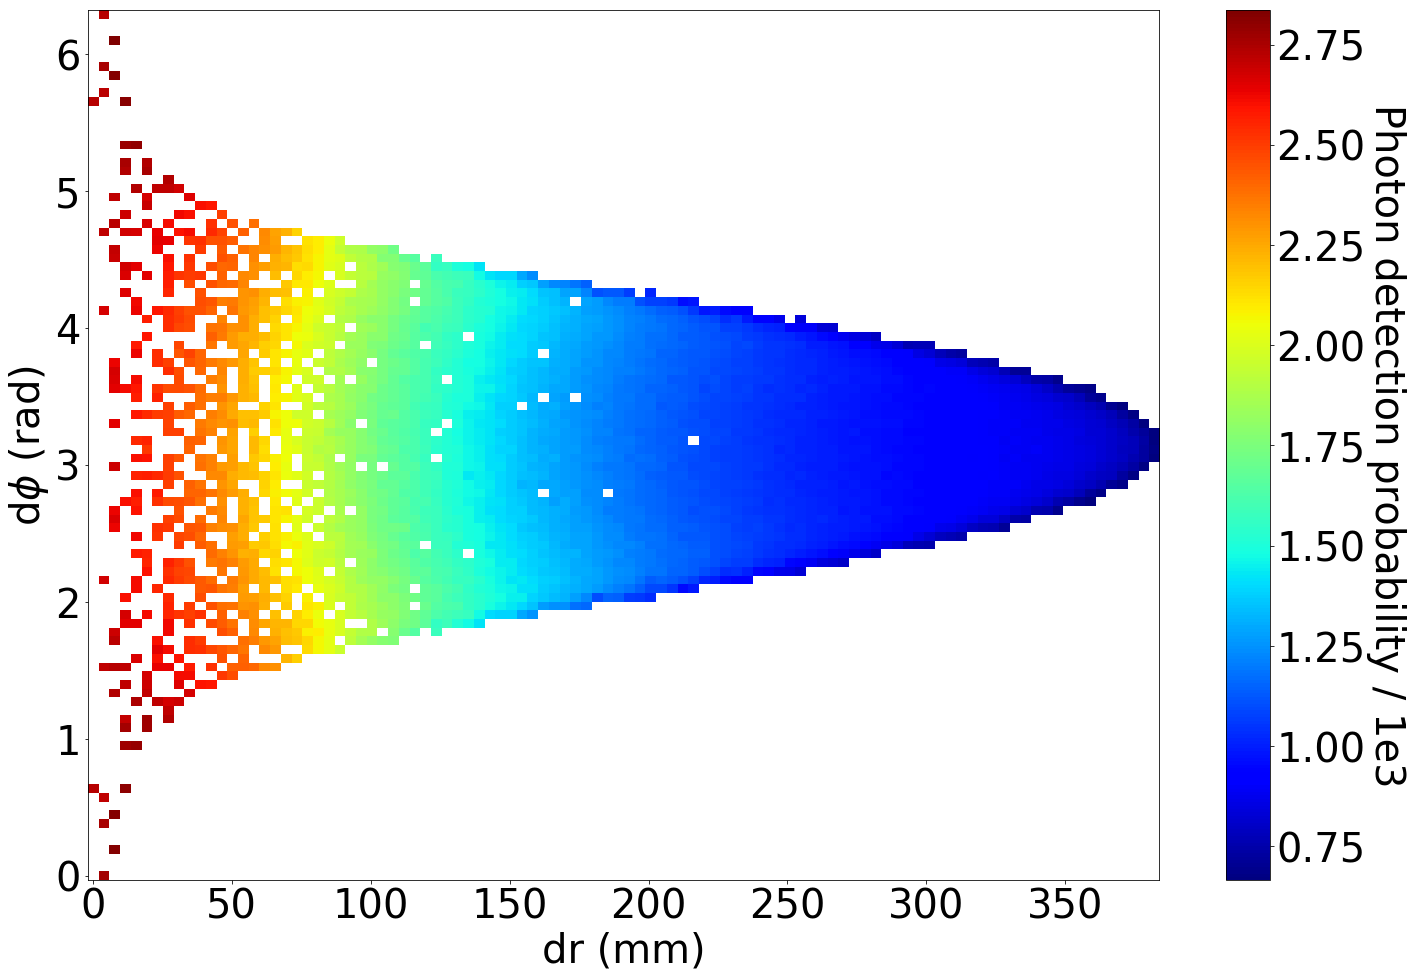

In [73]:
data = df_table[df_table.Z == z_max].copy()
data.Prob *= 1e3
for ring_no, ring in data.groupby("Ring"):
    plt.figure(figsize=(24, 16))
    x, y, z, u = fitf.profileXY(ring.dR, ring.dPhi, ring.Prob, dr_binning.size - 1, dphi_binning.size - 1,
                                xrange = (  dr_binning[0],   dr_binning[-1]),
                                yrange = (dphi_binning[0], dphi_binning[-1]))
    *_, cb = hstf.display_matrix(x, y, z, new_figure=False,
                                 cmap = "jet",
                                 cmin = 1e-8,
                                )
    plt.xlabel("dr (mm)")
    plt.ylabel("d$\phi$ (rad)")
    cb.set_label("Photon detection probability / 1e3", rotation=-90, labelpad=40)

    name = "inner" if ring_no == 0 else "outer"
    save(f"new_s1_dr_dphi_{name}_z_{z_max}.png")

In [331]:
dr_fit.head()

ring  dphi    z  dr_coeff         value        uncert
0     0     0  475         0  2.192393e-03  1.899806e-05
1     0     0  475         1  6.595187e-07  4.786978e-07
2     0     0  475         2  9.368667e-09  2.777412e-09
3     0     2  475         0  2.242881e-03  1.815353e-05
4     0     2  475         1 -7.696589e-07  4.393834e-07

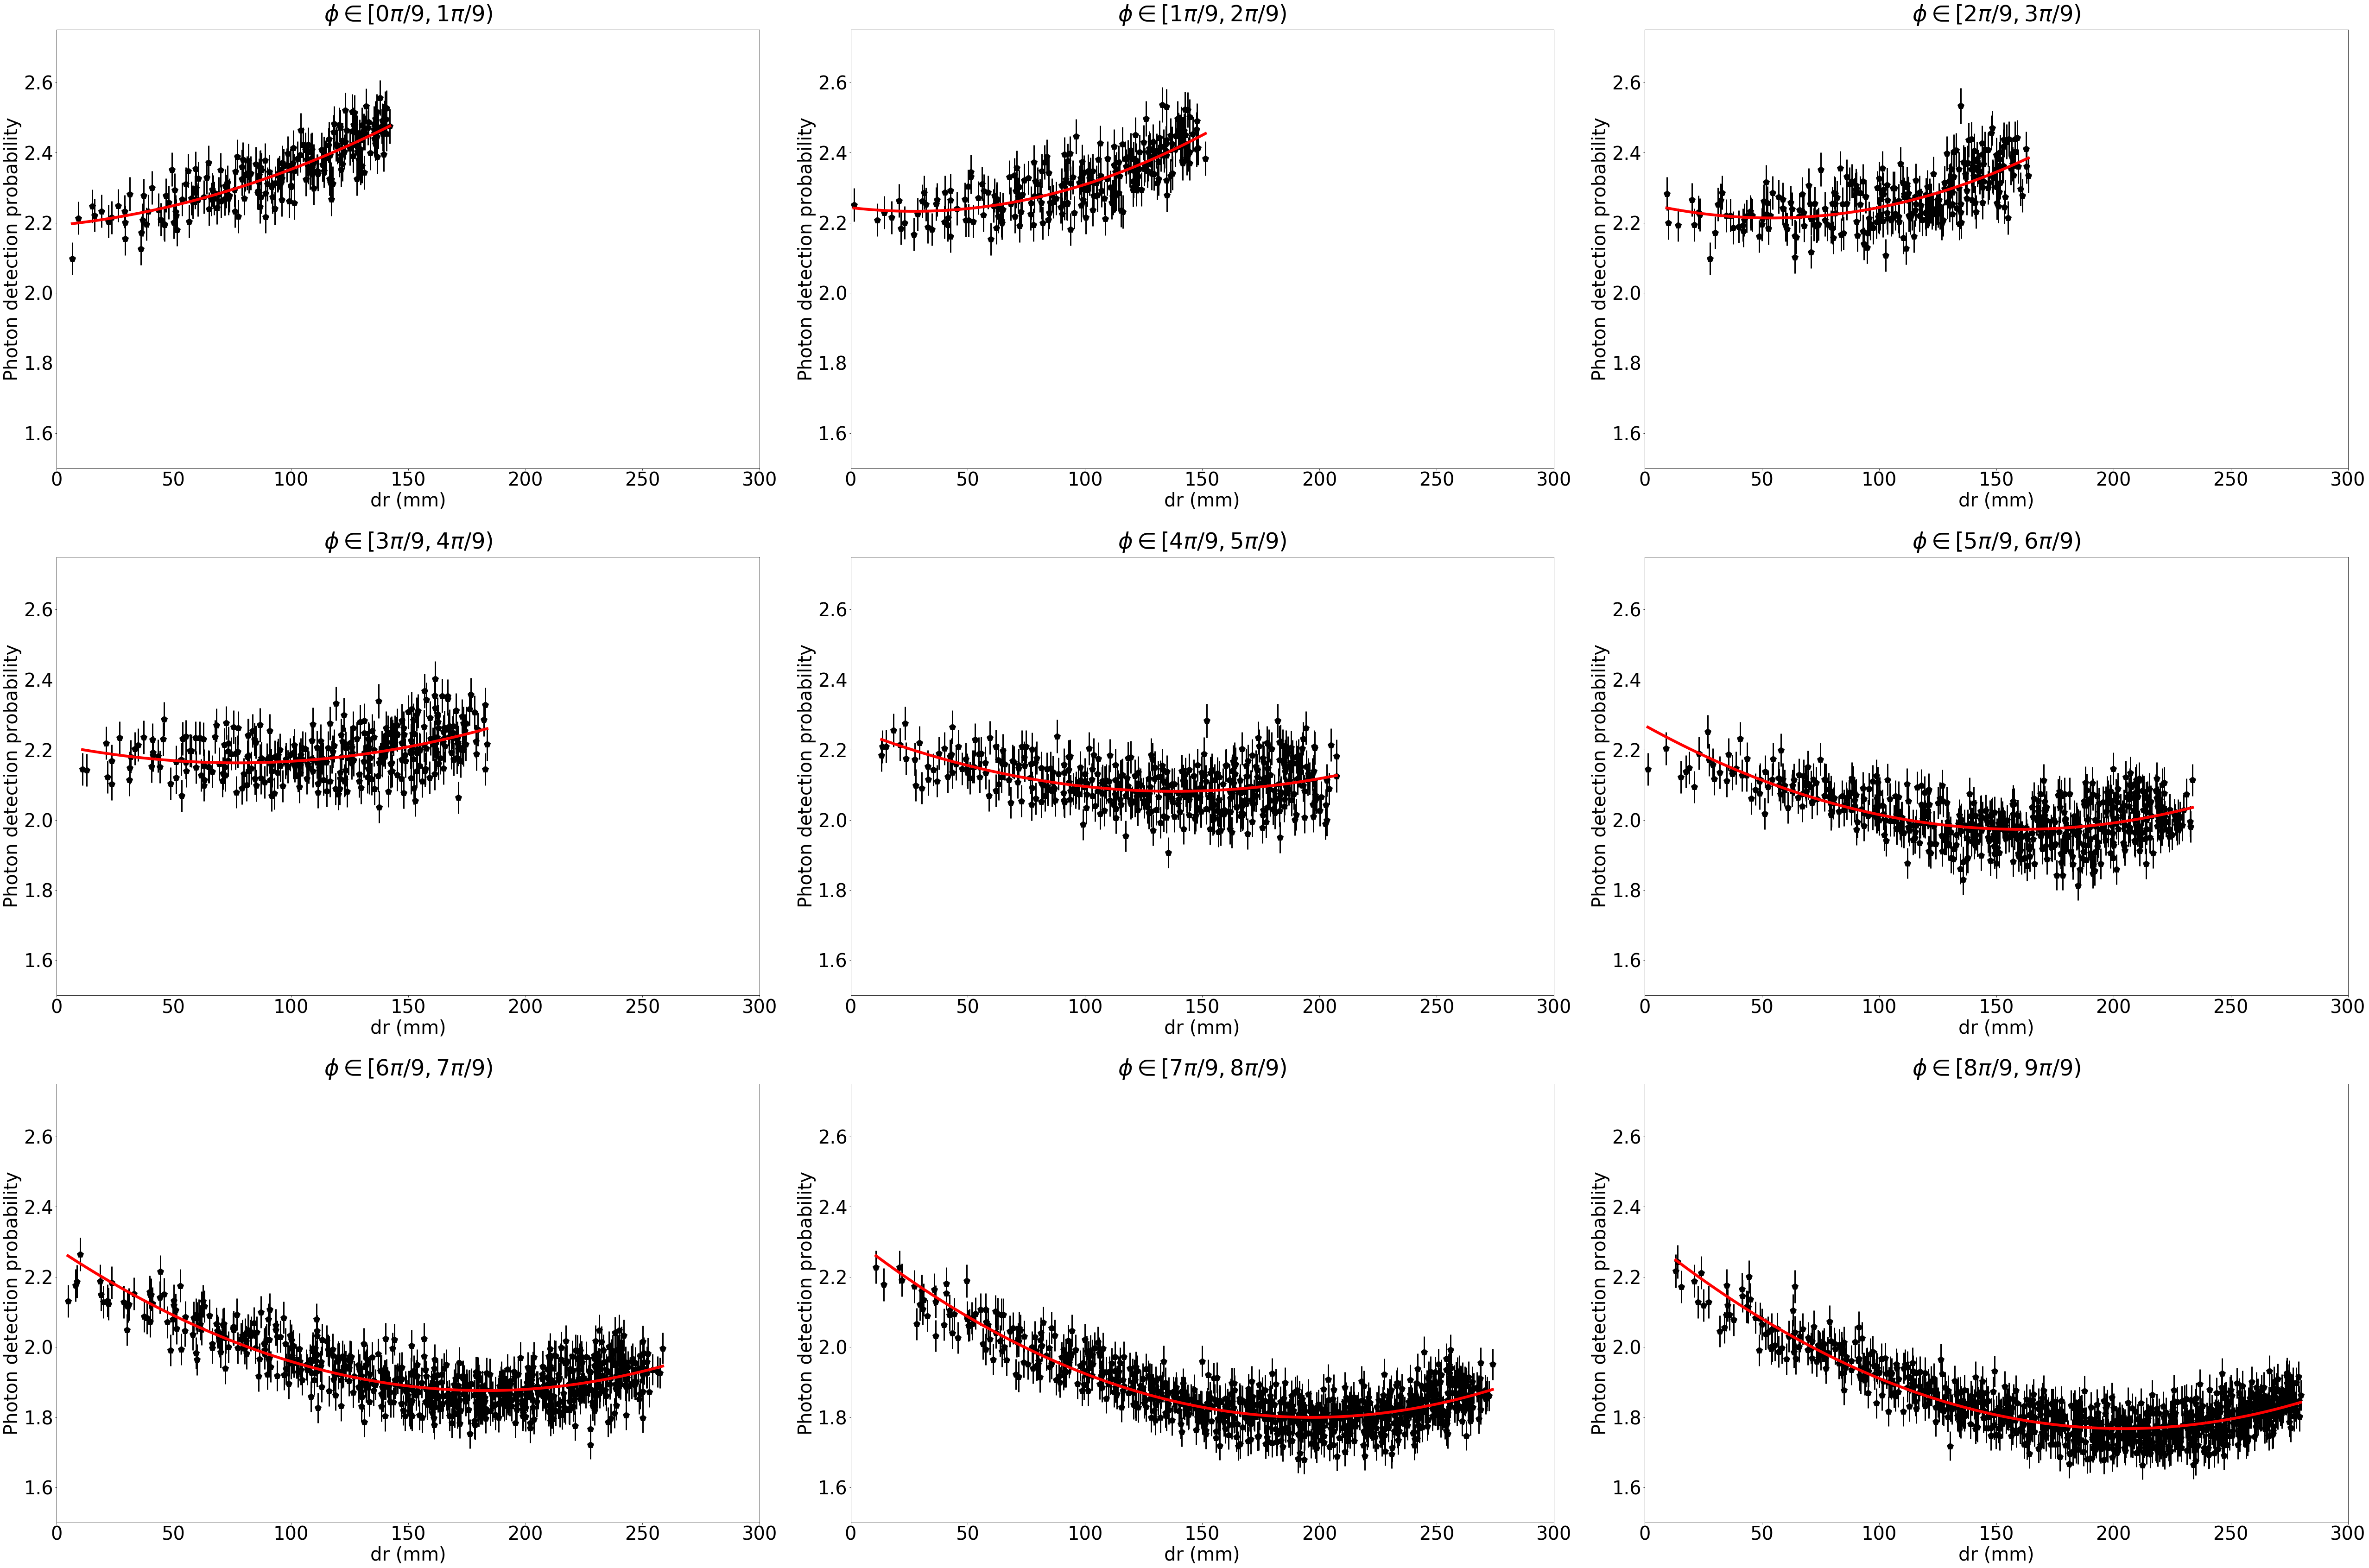

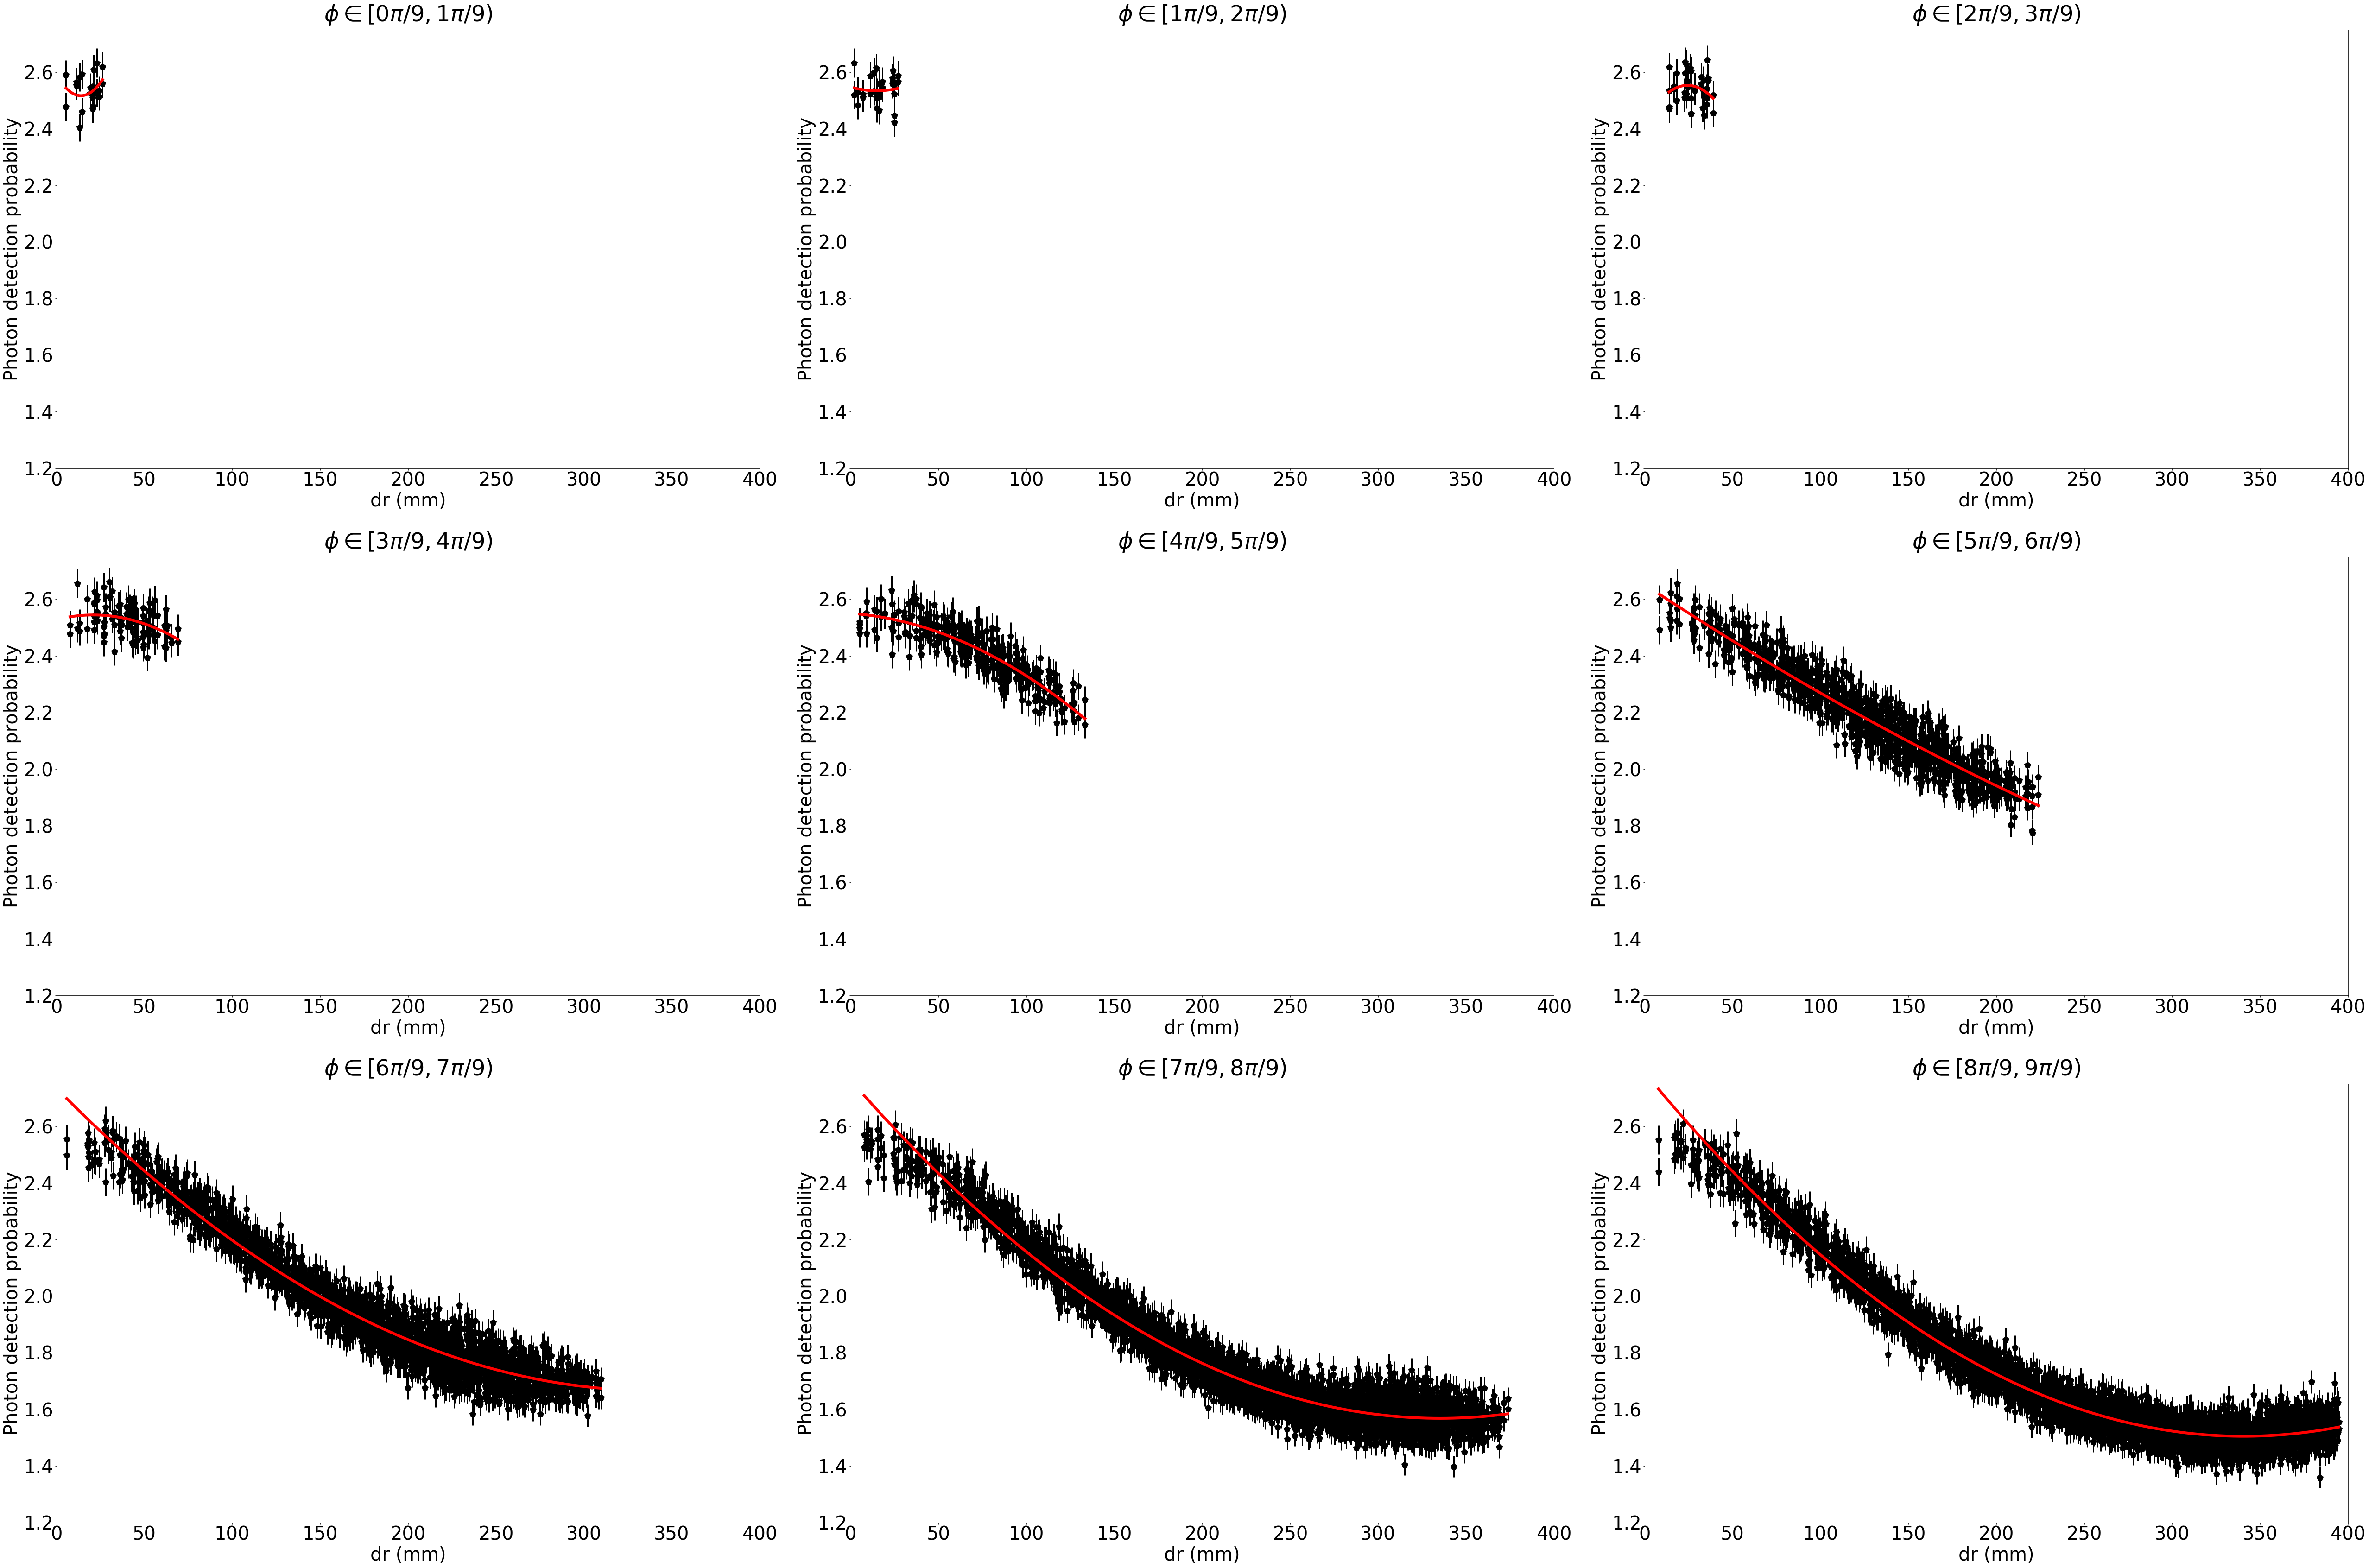

In [81]:
def build_dr_fun(df):
    def param(dr):
        return sum(row.value * dr**row.dr_coeff for _, row in df.iterrows())
    return param


zval = 475
for ring, name, xmax, ymin in zip(range(2), ("inner", "outer"), (300, 400), (1.5, 1.2)):
    plt.figure(figsize=(72, 48))
    for dphi in range(n_phi_sectors):
        drd = dr_data[((dr_data.ring == ring) & 
                       (dr_data.z    == zval) &
                       (dr_data.dphi == dphi)  )]
        drf = dr_fit [((dr_fit .ring == ring) & 
                       (dr_fit .z    == zval) &
                       (dr_fit .dphi == dphi)  )]

        plt.subplot (3, 3, dphi + 1)
        plt.errorbar(drd.dr, drd.prob * 1e3, drd.uncert * 1e3, fmt="pk", zorder=1)
        plt.xlim(   0, xmax)
        plt.ylim(ymin, 2.75)

        x = np.linspace(drd.dr.min(), drd.dr.max(), 201)
        y = build_dr_fun(drf)(x) * 1e3
        plt.plot(x, y, "r-", lw=6, zorder=2)

        plt.title(f"$\phi \in [{dphi}\pi/{n_phi_sectors}, {dphi + 1}\pi/{n_phi_sectors})$", fontdict={"verticalalignment":"bottom"})
        plt.xlabel("dr (mm)")
        plt.ylabel("Photon detection probability")

    plt.tight_layout()
    save(f"new_s1_dr_{name}_z_{zval + 5}.png")

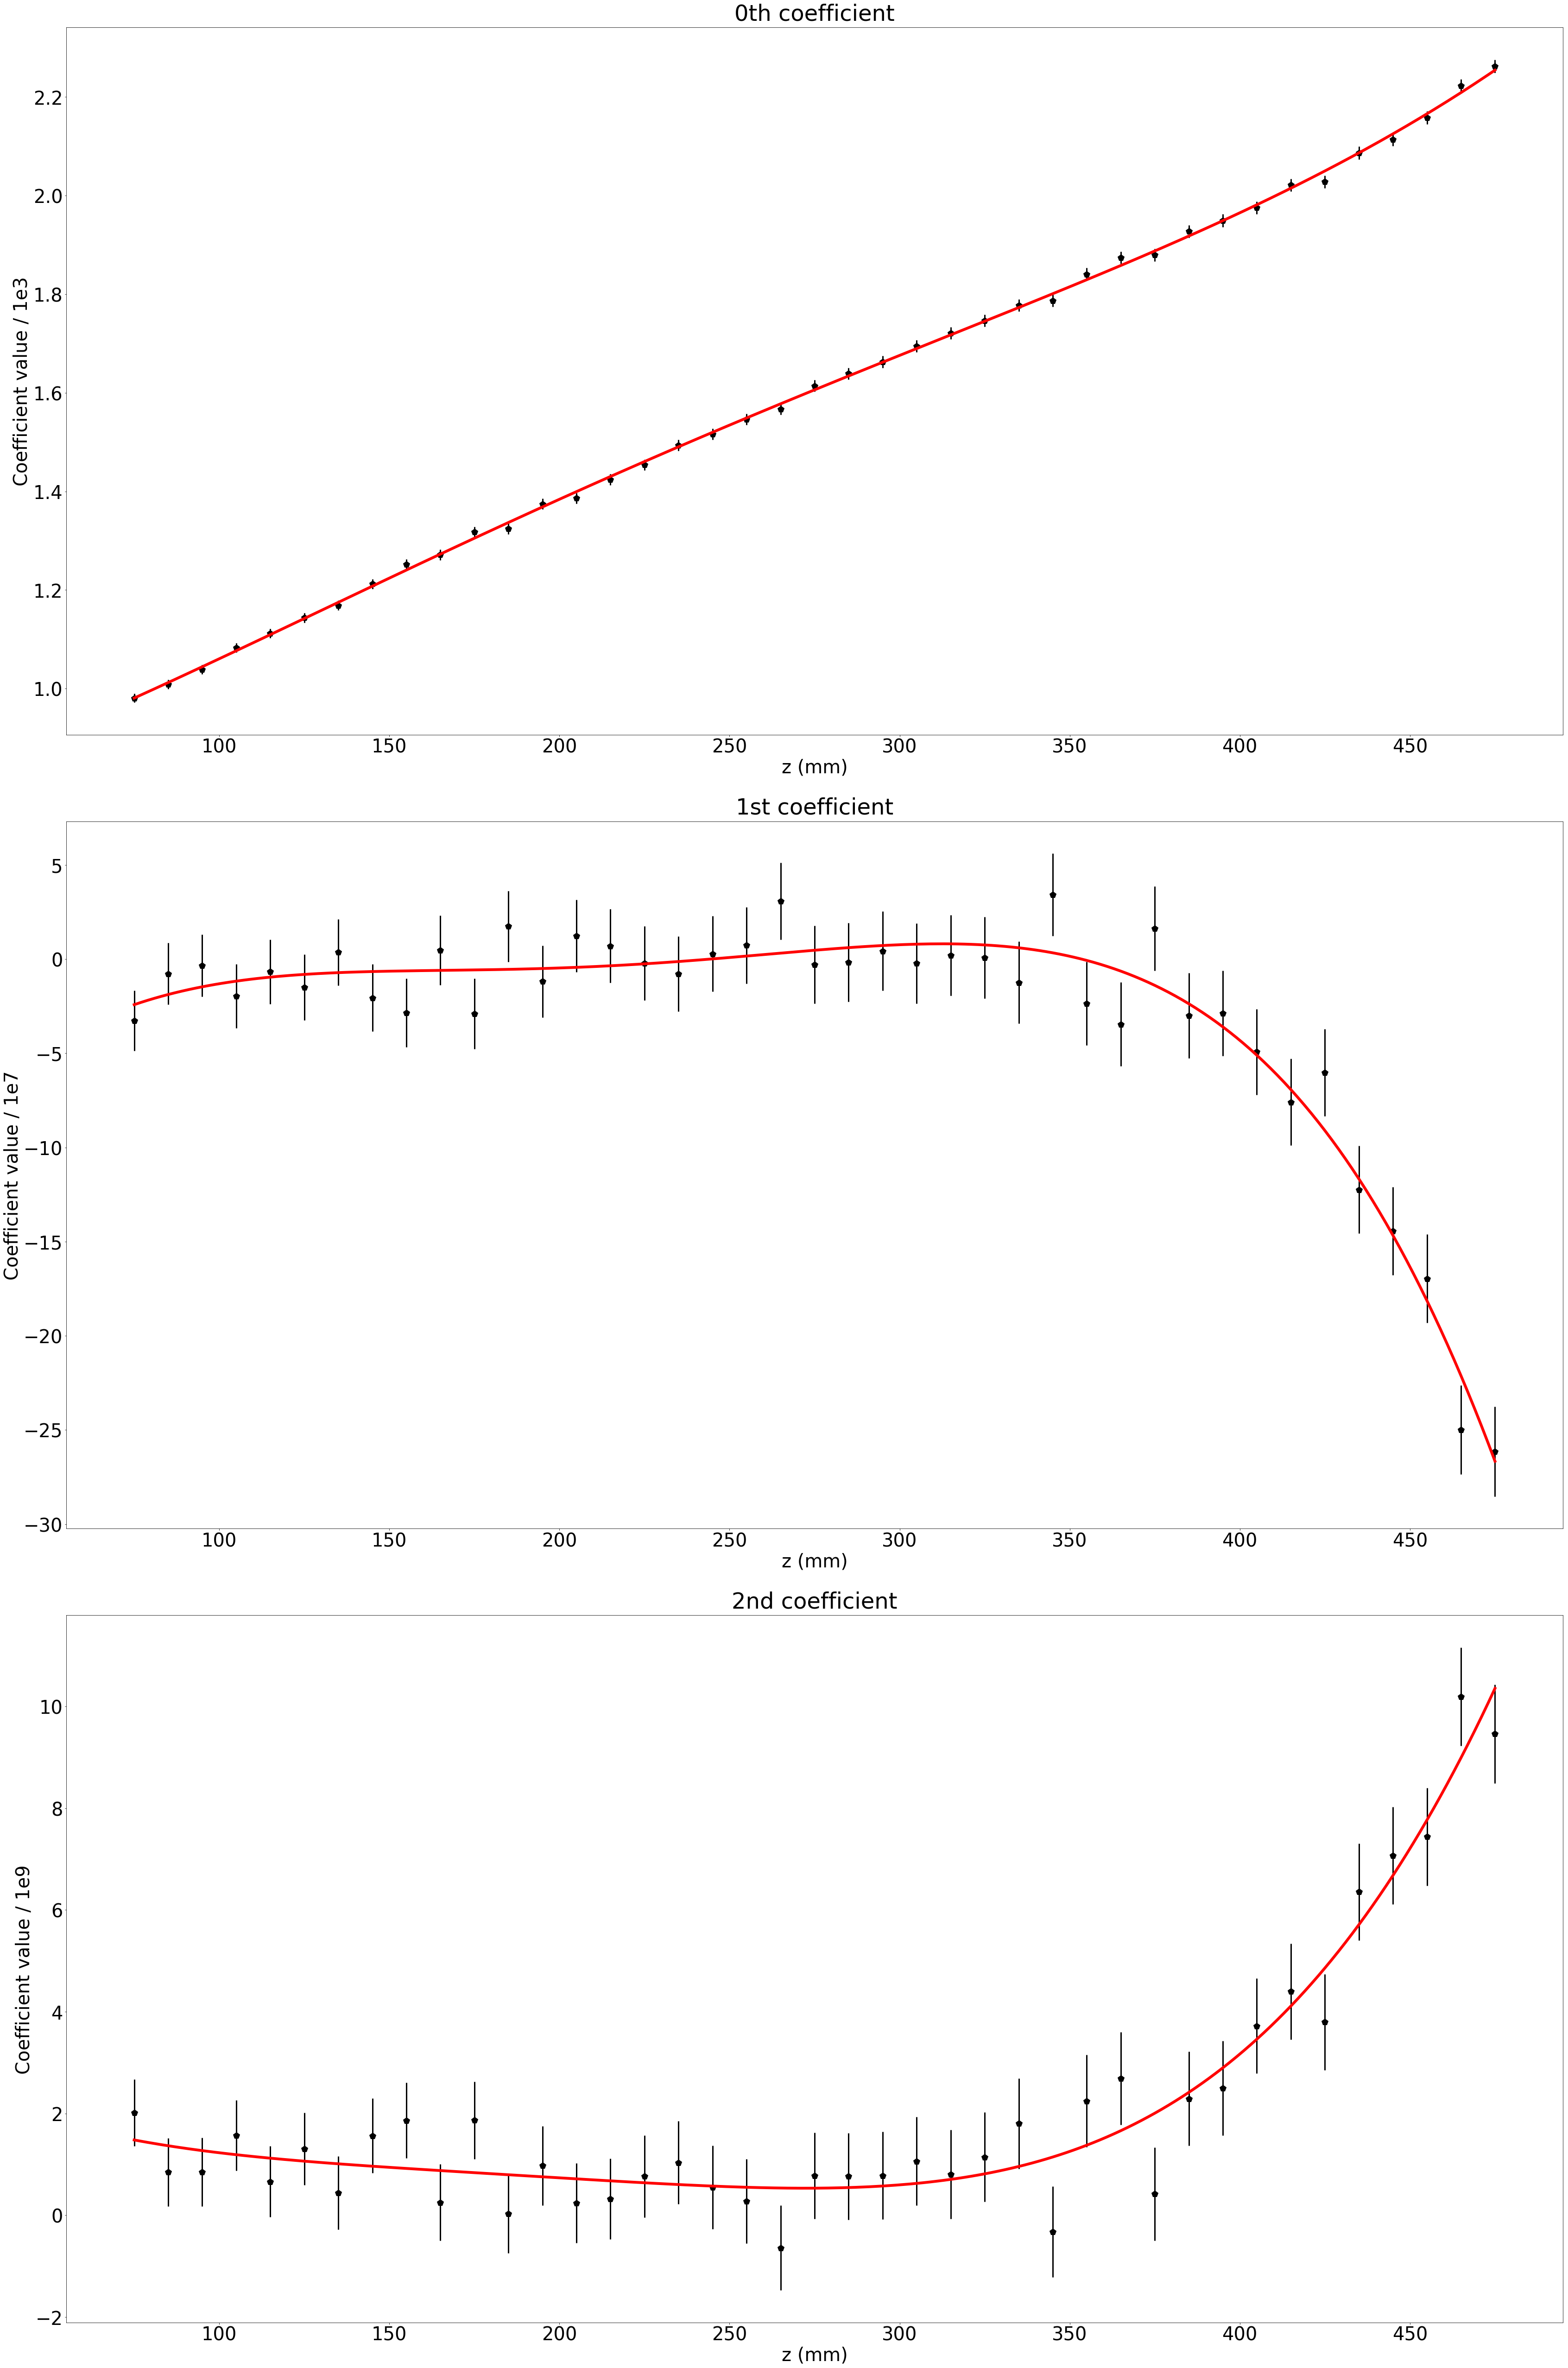

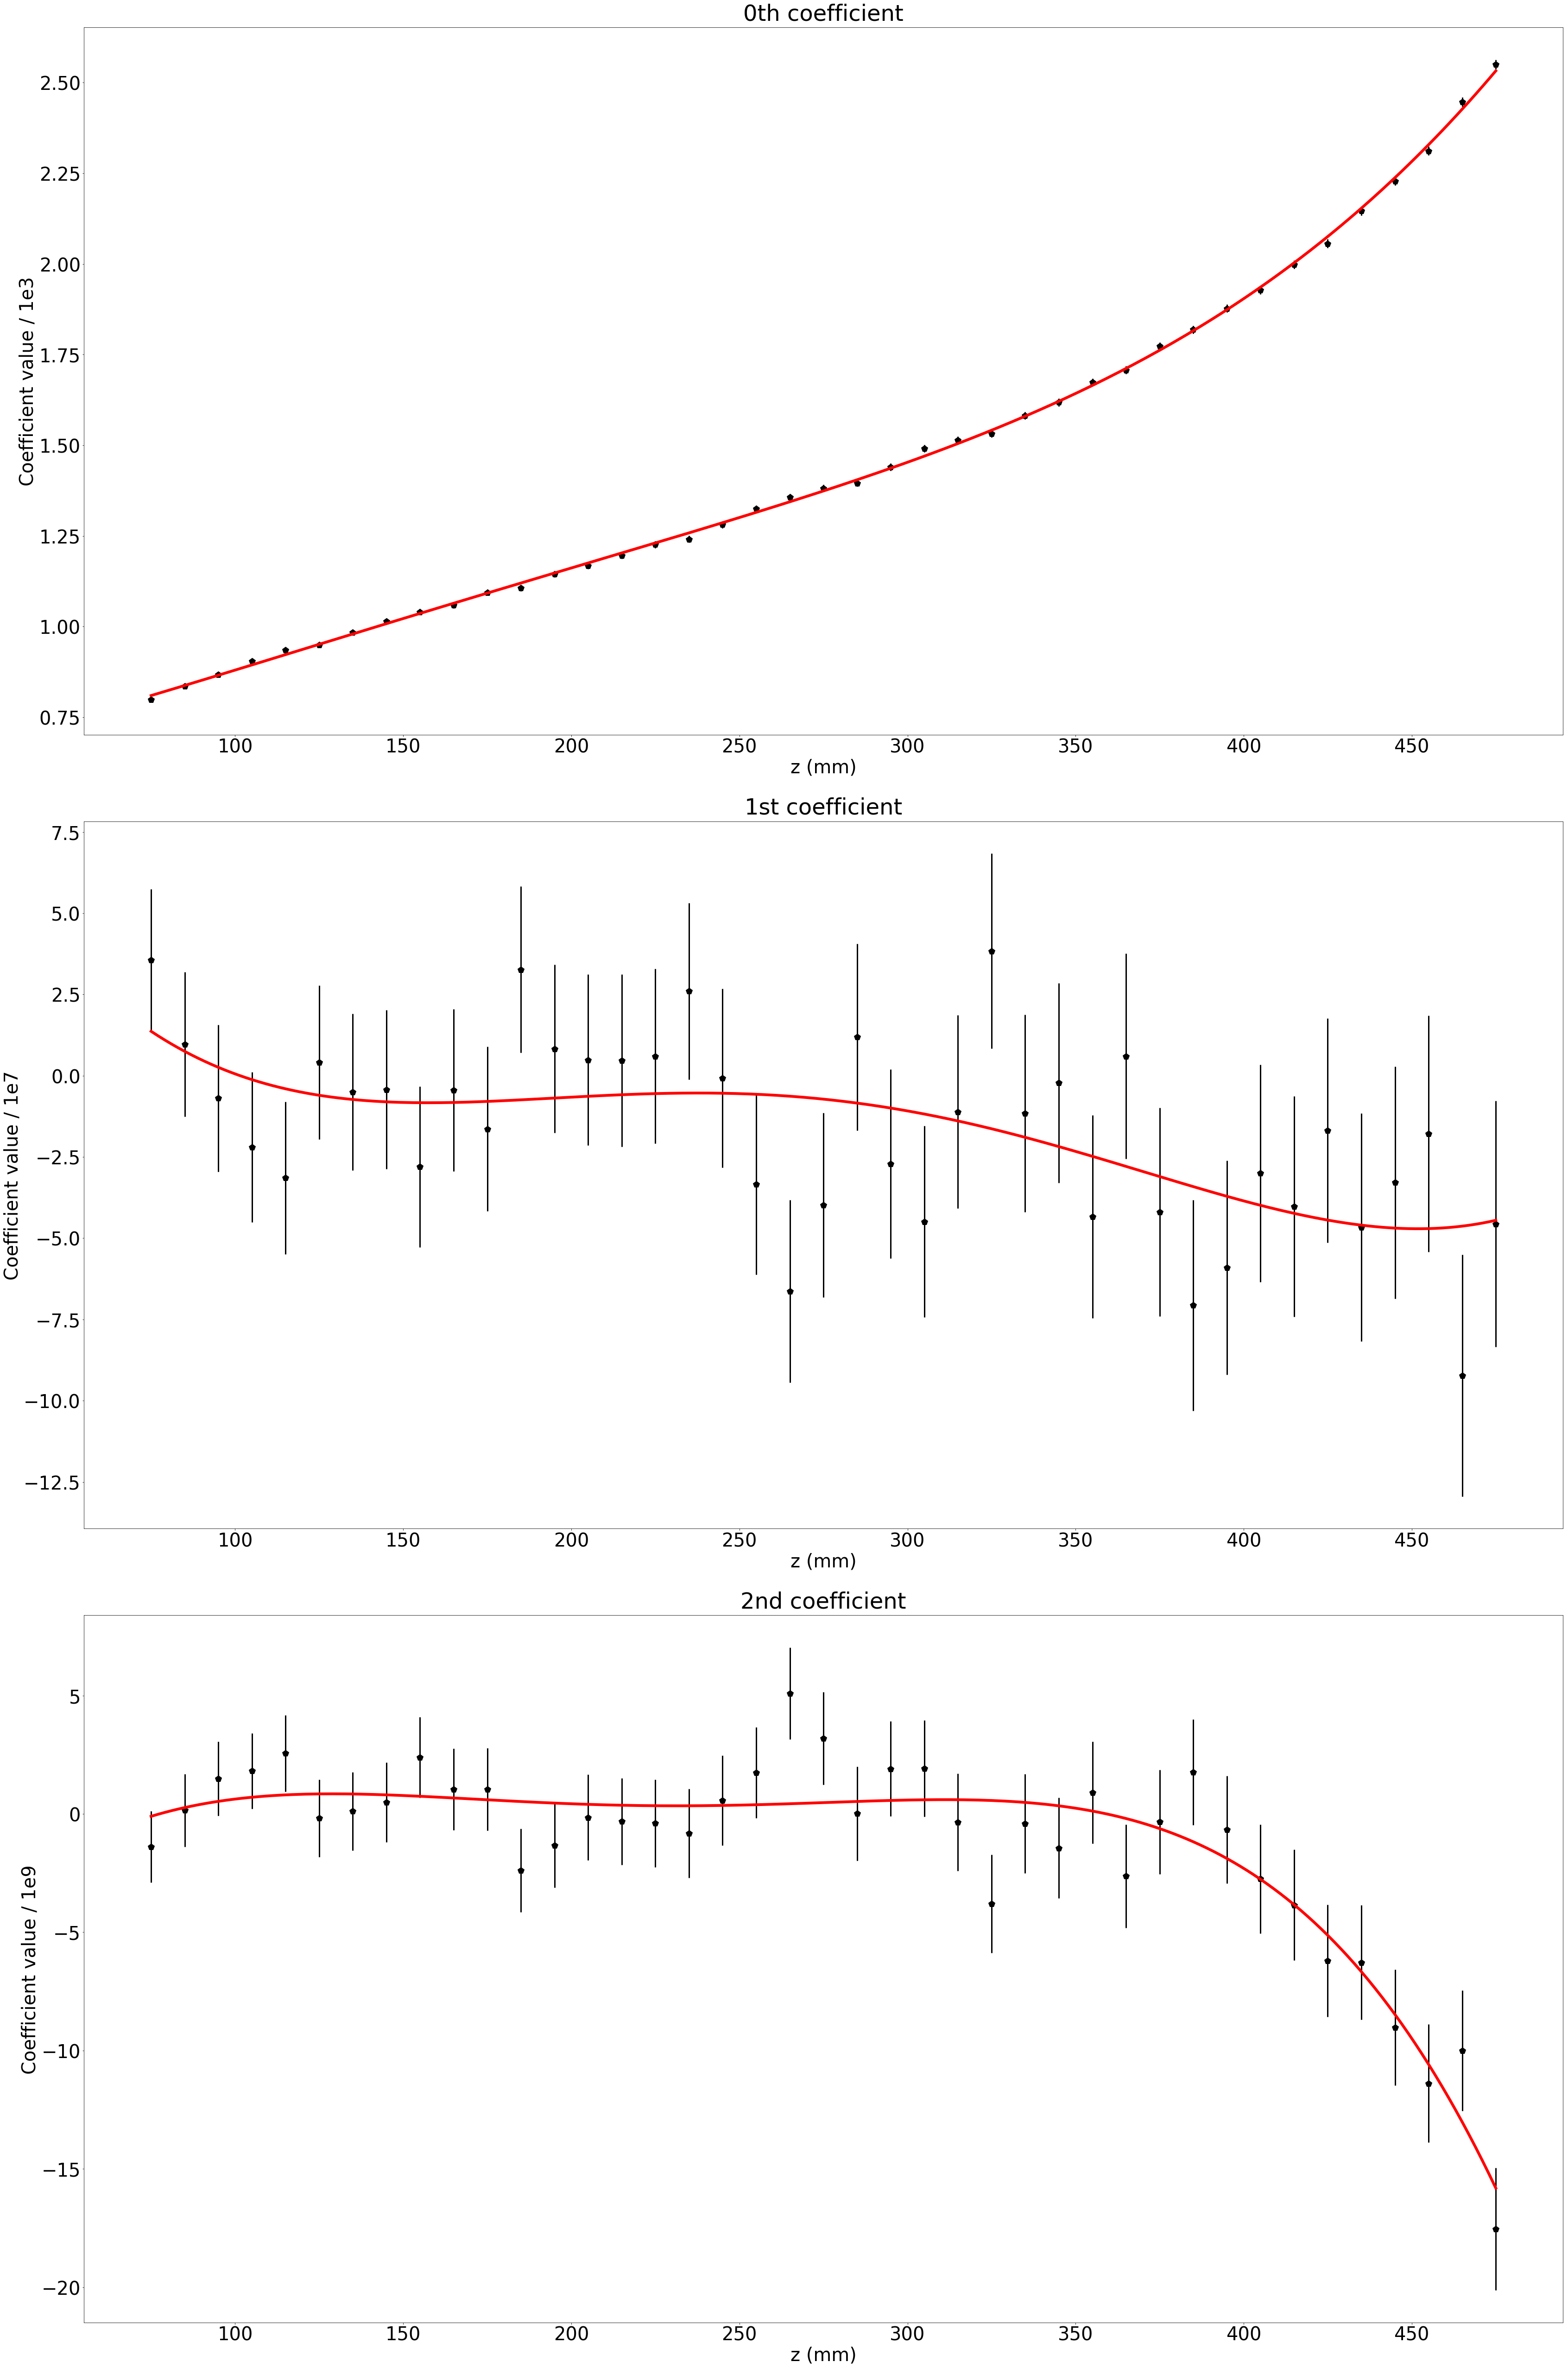

In [102]:
def build_z_fun(df):
    def param(z):
        return sum(row.value * z**row.z_coeff for _, row in df.iterrows())
    return param


dphi = 4
for ring, rname in enumerate(["inner", "outer"]):
#    plt.figure(figsize=(72, 48))
    plt.figure(figsize=(48, 72))
    for dr_c, pname in enumerate(["0th", "1st", "2nd"]):
        zd = z_data[((z_data.ring     == ring) & 
                     (z_data.dr_coeff == dr_c) &
                     (z_data.dphi     == dphi)  )]
        zf = z_fit [((z_fit .ring     == ring) & 
                     (z_fit .dr_coeff == dr_c) &
                     (z_fit .dphi     == dphi)  )]

        scale = 1/10**np.floor(np.log10(np.abs(np.mean(zd.value))))

        plt.subplot (3, 1, dr_c + 1)
        plt.errorbar(zd.z, zd.value * scale, zd.uncert * scale, fmt="pk", zorder=1)

        x = np.linspace(zd.z.min(), zd.z.max(), 201)
        y = build_z_fun(zf)(x) * scale
        plt.plot(x, y, "r-", lw=6, zorder=2)

        plt.title(f"{pname} coefficient", fontdict={"verticalalignment":"bottom"})
        plt.xlabel("z (mm)")
        plt.ylabel(f"Coefficient value / 1e{int(np.log10(scale))}")

    plt.tight_layout()
    save(f"new_s1_z_{rname}_z_dphi_{dphi}.png")

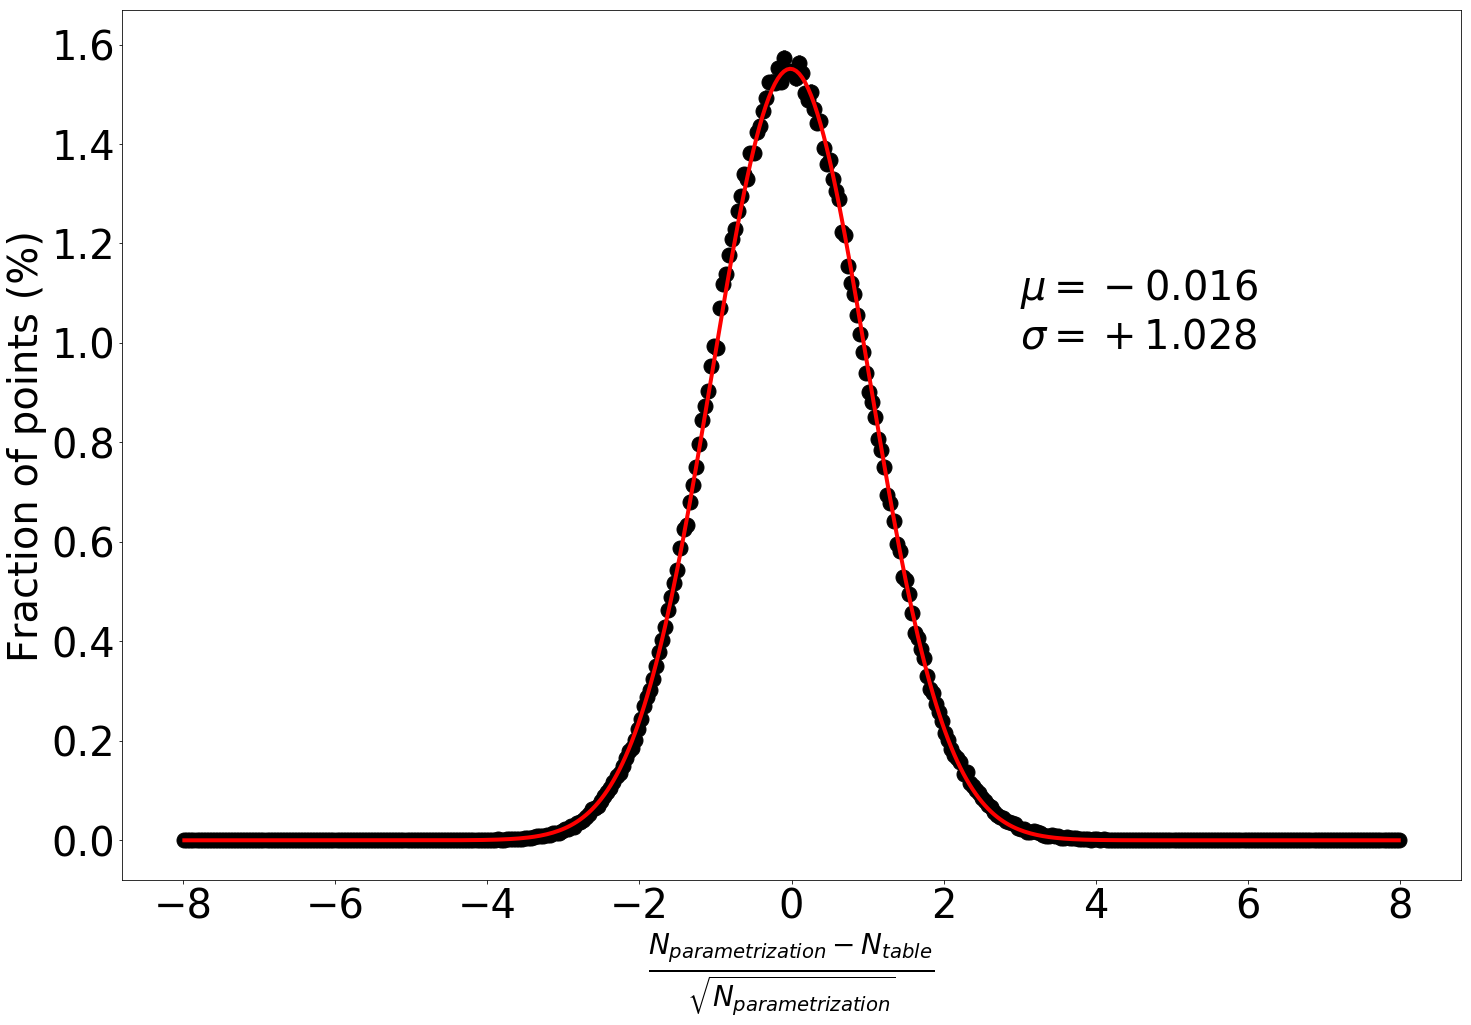

In [151]:
df       = pull_data[pull_data.r.isnull() & pull_data.z.isnull()].drop_duplicates("pull").copy()
total    = df.many.sum() * 0.01
sigma    = np.clip(np.sqrt(df.many), 5, np.inf)
df.many /= total
sigma   /= total
f        = fitf.fit(fitf.gauss, df.pull, df.many, (1, 0, 1),
                    sigma = sigma)

mu  = f"$\mu = {f.values[1]:+.3f} \pm {f.errors[1]:.3f}$"
sig = f"$\sigma = {f.values[2]:+.3f} \pm {f.errors[2]:.3f}$"
mu  = f"$\mu = {f.values[1]:+.3f}$"
sig = f"$\sigma = {f.values[2]:+.3f}$"

plt.errorbar(df.pull, df.many, sigma, np.diff(df.pull)[0]/2, "ok", zorder=1)
plt.plot    (df.pull, f.fn(df.pull), "r-", zorder=2, lw=4)
plt.text    (3, np.mean(plt.ylim()) * 1.25, "\n".join([mu, sig]))

pulldef = r"$\frac{N_{parametrization} - N_{table}}{\sqrt{N_{parametrization}}}$"
plt.xlabel(pulldef)
plt.ylabel("Fraction of points (%)")

save("new_s1_pull.png")

In [114]:
df

r   z  pull  many
0      NaN NaN -7.98   0.0
1      NaN NaN -7.94   0.0
2      NaN NaN -7.90   0.0
3      NaN NaN -7.86   0.0
4      NaN NaN -7.82   0.0
5      NaN NaN -7.78   0.0
6      NaN NaN -7.74   0.0
7      NaN NaN -7.70   0.0
8      NaN NaN -7.66   0.0
9      NaN NaN -7.62   0.0
10     NaN NaN -7.58   0.0
11     NaN NaN -7.54   0.0
12     NaN NaN -7.50   0.0
13     NaN NaN -7.46   0.0
14     NaN NaN -7.42   0.0
15     NaN NaN -7.38   0.0
16     NaN NaN -7.34   0.0
17     NaN NaN -7.30   0.0
18     NaN NaN -7.26   0.0
19     NaN NaN -7.22   0.0
20     NaN NaN -7.18   0.0
21     NaN NaN -7.14   0.0
22     NaN NaN -7.10   0.0
23     NaN NaN -7.06   0.0
24     NaN NaN -7.02   0.0
25     NaN NaN -6.98   0.0
26     NaN NaN -6.94   0.0
27     NaN NaN -6.90   0.0
28     NaN NaN -6.86   0.0
29     NaN NaN -6.82   0.0
...     ..  ..   ...   ...
177170 NaN NaN  6.82   0.0
177171 NaN NaN  6.86   0.0
177172 NaN NaN  6.90   0.0
177173 NaN NaN  6.94   0.0
177174 NaN NaN  6.98   0.0
177175 NaN NaN  7.02   0.0
177176 NaN NaN  7.06   0.0
177177 NaN NaN  7.10   0.0
177178 NaN NaN  7.14   0.0
177179 NaN NaN  7.18   0.0
177180 NaN NaN  7.22   0.0
177181 NaN NaN  7.26   0.0
177182 NaN NaN  7.30   0.0
177183 NaN NaN  7.34   0.0
177184 NaN NaN  7.38   0.0
177185 NaN NaN  7.42   0.0
177186 NaN NaN  7.46   0.0
177187 NaN NaN  7.50   0.0
177188 NaN NaN  7.54   0.0
177189 NaN NaN  7.58   0.0
177190 NaN NaN  7.62   0.0
177191 NaN NaN  7.66   0.0
177192 NaN NaN  7.70   0.0
177193 NaN NaN  7.74   0.0
177194 NaN NaN  7.78   0.0
177195 NaN NaN  7.82   0.0
177196 NaN NaN  7.86   0.0
177197 NaN NaN  7.90   0.0
177198 NaN NaN  7.94   0.0
177199 NaN NaN  7.98   0.0

[800 rows x 4 columns]

In [ ]:
pull_binning = np.linspace(-10, 10, 100)
y, x = np.histogram(pull[np.isfinite(pull)], pull_binning)
x    = x[:-1] + np.diff(x) / 2
f    = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))

plt.hist  (pull, pull_binning, histtype="step", color="k", lw=3)
plt.plot  (x, f.fn(x), "r-", lw=3)
plt.text  (0.7, 0.7, f"µ = {f.values[1]:.3f}\nσ = {f.values[2]:.3f}", transform=plt.gca().transAxes, fontsize=25)
plt.xlabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")
plt.ylabel("Number of occurrences")

In [ ]:
r_binning = np.linspace(0, 215, 101)
plt.hist2d(r[rg==1], pull[rg==1], (r_binning, pull_binning))
plt.xlabel( "r (mm)")
plt.ylabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")

In [ ]:
plt.hist2d(z, pull, (z_binning, pull_binning))
plt.xlabel( "z (mm)")
plt.ylabel(r"$\frac{N_{p} - N_{t}}{\sqrt{N_{p}}}$")

fitf.profileX(z, pull, z_binning.size -1, (z_binning[0], z_binning[-1]), std=True)

In [ ]:
ring     =   0
z        = 250
nphi     =   2
dr, p, u = dr_profiles        [ring][nphi][z]
f        = dr_parametrizations[ring][nphi][z]
dr_      = np.linspace(0, 230, 100)

plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
plt.plot    (dr_, f.fn(dr_) * 1e5, "r-")

plt.xlabel("dr (mm)")
plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()

In [ ]:
ring =   1
z    =  280 - 200
dr_  = np.linspace(0, 230, 100)

plt.figure(figsize=(24, 24))
for nphi in range(9):
    dr, p, u = dr_profiles        [ring][nphi][z]
    f        = dr_parametrizations[ring][nphi][z]
    
    plt.subplot(3, 3, nphi + 1)
    plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
#    plt.scatter(dr , p * 1e5, c="k")
    plt.plot    (dr_, f.fn(dr_) * 1e5, "r-")
    plt.xlim(0, dr.max() * 1.1)
    plt.ylim(0, p.max() * 1.1 * 1e5)
    plt.xlabel("dr (mm)")
    plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()

In [ ]:
ring = 0
dphi = 0
z_   = np.linspace(0, z_max, 100)

plt.figure(figsize=(24, 24))
for r in range(polynomial_degree_dr + 1):
    z, c, u = z_profiles        [ring][dphi][r]
    f       = z_parametrizations[ring][dphi][r]
    
    plt.subplot (polynomial_degree_dr + 1, 1, r + 1)
    plt.errorbar(z , c, u, fmt="pk")
    plt.plot    (z_, f.fn(z_), "r-")

    plt.ylim  ((c-u).min(), (c+u).max())
    plt.xlabel("z (mm)")
    plt.ylabel("Coefficient")
plt.tight_layout()

In [ ]:
ring =   0
z    = 480
dr_  = np.linspace(0, 150, 100)

plt.figure(figsize=(24, 24))
for nphi in range(9):
    dr, p, u = dr_profiles        [ring][nphi][z]
    f        = dr_parametrizations[ring][nphi][z]
    
    plt.subplot(3, 3, nphi + 1)
#    plt.errorbar(dr , p * 1e5, u * 1e5, fmt="kp")
    plt.scatter(dr , p, c="k")
    plt.plot    (dr_, f.fn(dr_), "r-")
    plt.ylim(0, p.max() * 1.1)
    plt.xlabel("dr (mm)")
    plt.ylabel("Photon detection probability / 1e5")
plt.tight_layout()